In [1]:
import numpy as np
import pandas as pd
import math
import cmath
import matplotlib.pyplot as plt
import tifffile as tiff
import os
from scipy import stats
from scipy import ndimage as nd
from matplotlib.colors import LinearSegmentedColormap
from matplotlib_scalebar.scalebar import ScaleBar
from scipy.ndimage import gaussian_filter
from numpy import linalg as LA
from scipy.stats import kurtosis, skew
from sklearn.mixture import GaussianMixture
from openpyxl import load_workbook
from pathlib import Path
import sys

In [2]:
class MuellerMatrix(np.ndarray):
    
    #A class for handling Mueller matrices 
    #Parameters
    #----------
    #x : 4x4 list or array of float or int, optional
    #    Default is a zero Mueller matrix
    
    def __new__(cls,*x):
        if (len(x)==0):
            m = np.array(((0.,0.,0.,0.),
                          (0.,0.,0.,0.),
                          (0.,0.,0.,0.),
                          (0.,0.,0.,0.))).view(MuellerMatrix)
            return m
        if (len(x)==16):
            m = np.asarray(x,dtype=float).view(MuellerMatrix)
            m = np.resize(m,(4,4))
            return m
        if (len(x)==4):
            for xx in x:
                if (len(xx)!=4):
                    raise Exception("Mueller matrix must be 4x4 real matrix")
            x = [x[0],x[1],x[2],x[3]]
            m = np.asarray(x,dtype=float).view(MuellerMatrix)
            return m
        if (len(x)==1):
            m = np.asarray(x,dtype=float).view(MuellerMatrix)
            m = m.reshape((4,4))
            return m
        raise Exception("Mueller matrix must be a 4x4 real matrix")

 
     #def __mul__(a,b):
#         # Multiply two Mueller matrices, or a Mueller matrix with 
#         # a Stokes vector, or multiply by a scalar 
        
#         if isinstance(b,MuellerMatrix):
#             return a.dot(b)
#         if isinstance(b,StokesVector):
#             return StokesVector(a.dot(b))
#         if isinstance(b,(float,int)):
#             return MuellerMatrix(a.dot(b))
#         raise Exception("Mueller matrices should only be multiplied "
#                 "by Mueller matrices, Stokes vectors, floats, or ints")

#     __matmul__ = __mul__
    
    def __truediv__(a,b):
        #Divide a Mueller matrix by a scalar
        if isinstance(b,int) or isinstance(b,float):
            return super().__truediv__(b)
        raise Exception("Can only divide a Mueller matrix by a float or int")

    def __pow__(a,b):

        #Mueller matrix to the power b.
        #Parameters
        #----------
        #b : float
        #    The power
        #Returns
        #-------
        #    : MuellerMatrix
        #      Matrix power operation
        
        Q, W = np.linalg.eig(a)
        Q = Q**b
        return W.dot(np.diag(Q)).dot(np.linalg.inv(W)).real
        
    def Tmax(self):

        #Return the maximum transmittance.
        
        #Returns
        #-------
        #Tmax : float
        #       The maximum transmittance of the MuellerMatrix
        
        return self[0,0]+math.sqrt(self[0,1]**2+self[0,2]**2+self[0,3]**2)

    def Tmin(self):
    
        # Return the minimum transmittance.
        
        # Returns
        # -------
        # Tmax : float
        #The minimum transmittance of the MuellerMatrix

        return self[0,0]-math.sqrt(self[0,1]**2+self[0,2]**2+self[0,3]**2)

    def diattenuation(self):

        # Return the diattenuation.
        
        # Returns
        # -------
        # diattenuation : float
        # The diattenuation

        return math.sqrt(self[0,1]**2+self[0,2]**2+self[0,3]**2)/self[0,0]

    def linear_diattenuation(self):

        #Return the linear diattenuation.
        
        #Returns
        #-------
        #diattenuation : float
        #                The linear diattenuation
        
        return math.sqrt(self[0,1]**2+self[0,2]**2)/self[0,0]

    def polarization_dependent_loss(self):

        #Return the polarization dependent loss.
        #Returns
        #-------
        #pdl : float
        #      The polarization dependent loss

        return 10.*math.log(self.Tmax()/self.Tmin())/math.log(10.);

    def polarizance(self):

        # Return the polarizance.
        # Returns
        # -------
        # polarizance : float
        #              The polarizance

        return math.sqrt(self[1,0]**2+self[2,0]**2+self[3,0]**2)/self[0,0]

    def depolarization_index(self):

        #Return the depolarization index.
        #Returns
        #-------
        #PI : float
        #     The depolarization index
        
        mmt = (self.T).dot(self)
        return math.sqrt((mmt[0,0]+mmt[1,1]+mmt[2,2]+mmt[3,3]-self[0,0]**2)/(3*self[0,0]**2))

    def extinction_ratio(self):
        
        #Return the extinction ratio.
        #Returns
        #-------
        
        #ER : float
        #     The extinction ratio

        return self.Tmax()/self.Tmin()

    def rotate(self,angle):
        
        #Return a Mueller matrix rotated by an angle.
        #The angle is measured clockwise looking into the beam.
        #Parameters
        #----------
        #angle : float
        #        The angle in radians
        #Returns
        #-------
        #M : MuellerMatrix
        #    Mueller matrix rotated by angle

        sina = math.sin(angle)
        cosa = math.cos(angle)
        R = JonesMueller([[cosa,sina],[-sina,cosa]])
        return R @ self @ R.T

    def parity(self):
        
        #Mueller matrix with a parity conversion.
        #Returns
        #-------
        #M : MuellerMatrix
        #    Mueller matrix for a parity conversion

        mm = self.copy()
        mm[0,2] = -mm[0,2]
        mm[0,3] = -mm[0,3]
        mm[1,2] = -mm[1,2]
        mm[1,3] = -mm[1,3]
        mm[2,0] = -mm[2,0]
        mm[2,1] = -mm[2,1]
        mm[3,0] = -mm[3,0]
        mm[3,1] = -mm[3,1]
        return mm

    def transpose(self):
    
        #Mueller matrix transpose.
        #Returns
        #-------
        #M : MuellerMatrix
        #    The transposed Mueller matrix

        return self.T

    def inverse(self):

        #Mueller matrix inverse.
        #Returns
        #-------
        #M : MuellerMatrix
        #    The inverted Mueller matrix

        return np.linalg.inv(self)

    def valid(self):
        
        #Test if a matrix is a Stokes-Stokes mapping matrix.
        #Uses the condition described in C.R. Givens and A.B. Kostinski, 
        #'A simple necessary and sufficient condition on physically realizable 
        #Mueller matrices,' Journal of Modern Optics 40, 471-481 (1993).
        #Returns 
        #-------
        #    bool
        #    True if the matrix will always map a valid Stokes vector to a 
        #    valid Stokes vector; otherwise, False.
       
        M = self + 1E-10*self[0,0]*MuellerDiagonal([1,0,0,0])
        G = MinkowskiG
        MM = G @ M.T @ G @ M
        Q, W = np.linalg.eig(MM)
        W = np.array(W.T)
        
        imax=0
        max = -1E308
        ww = W[0]
        a = (Q @ np.conj(Q)) *1E-14
        for q,w in zip(Q,W):
            if abs(q.imag)> a:
                return False
            if (abs(q)>max):
                max = abs(q)
                ww = w.copy()

        ww = ww/ww[0]
        for i in range(1,4):
            if abs(ww[i].imag) > a:
                return False
        if 1 < ww[1].real**2+ww[2].real**2+ww[3].real**2:
            return False
        return True

    def physically_valid(self):
        
        #Test if a matrix is physically valid.
        #The function physically_valid() calculates the Mueller matrix coherency
        #matrix, which is the coherency matrix for the four Jones-Mueller 
        #matrices generated by the Pauli matrices. This coherency matrix must be
        #a valid coherency matrix (positive semi-definite) if the matrix is the
        #convex sum of Jones-Mueller matrices.  This test is a more stringent 
        #test than valid() for the validity of the Mueller matrix.
        #See B.N. Simon, et al, "A complete characterization of pre-Mueller and 
        #Mueller matrices in polarization optics," 
        #J. Opt. Soc. Am. A 27(2), 188-199 (2010).
        #Returns 
        #-------
        #    bool
        #    True if the matrix is physically valid, that is, if it is a convex
        #    sum of Jones-Mueller matrices.
    
        h = MuellerToHermitian(self)
        Q, W = np.linalg.eig(h)
        a = (Q @ np.conj(Q)) *1E-8
        for q in Q:
            if q.real < -a:
                return False
            if abs(q.imag) > a:
                return False
        return True
    
    def Closest_NonDepolarizing(self):

        #Return the largest matrix in the Cloude decomposition, which may be
        #interpreted as the closest non-depolarizing Mueller matrix.
        #Returns
        #-------
        #M : MuellerMatrix
        #    The largest matrix in the Cloude decomposition.

        M = self.Cloude_Decomposition()
        return M[0-rank]

    def normalized(self):

        return self/self[0,0]

    def entropy(self):
        
        h = MuellerToHermitian(self)
        Q, W =  np.linalg.eig(h)
        result = 0.
        sumQ = np.sum(Q).real
        for q in Q:
            Pi = abs(q)/sumQ
            if Pi>0:
                result += Pi*np.log(Pi)
        return -result/np.log(4.)

In [3]:
# Functions 
def Stokes_dict_in(H, V, P, B, R, L):
    storage = {}
    storage['Iin'] = ((H+V)+(P+B))/2
    storage['Qin'] = H-V
    storage['Uin'] = P-B
    storage['Vin'] = R-L
    return storage

def Stokes_dict_out(H, V, P, B, R, L):
    storage = {}
    storage['Iout'] = ((H+V)+(P+B))/2
    storage['Qout'] = H-V
    storage['Uout'] = P-B
    storage['Vout'] = R-L
    return storage
def MuellerUnit(attenuation=1):
    
    #Return a unit Mueller matrix
    #Arguments
    #--------
    #attenuation : float, optional
    #              Default is 1 
    
    a = attenuation
    return MuellerMatrix([[a,0,0,0],[0,a,0,0],[0,0,a,0],[0,0,0,a]])
def Lu_Chipman_Decomposition(M):
    
    # Return a depolarizer, a retarder, and a diattenuator whose ordered product is the Mueller matrix. 
    # See: S.-Y. Lu and R.A. Chipman, "Interpretation of Mueller matrices based on polar decomposition,
    # " J. Opt. Soc. Am. A **13**, 1106-1113 (1996).
    # Parameters
    # ----------
       # M : MuellerMatrix - The matrix to be decomposed
    # Returns
    # -------
    #   depolarizer : MuellerMatrix
    #   retarder : MuellerMatrix
    #   diattenuator : MuellerMatrix
    #        M = depolarizer @ retarder @ diattenuator

    diattenuator = MuellerMatrix() # Caused by having different transmittance values for diff incident polarization states (basically change of transmittance because of the change in polarization??)
    retarder = MuellerMatrix()  # Magnitude: Total phase delay between fastest and slowest propagating states, fast axis: state on poincare sphere representing fastest-propagating polarization state through the sample 
    depolarizer = MuellerMatrix()   # Confirm if this is the ability to reduce degree of polarization of incident light 
    
    # The diattenuator takes the net transmittance of the matrix.
    # See L&C, Eq. (18)
    Tu = M[0,0]

    # If the transmittance is zero-no light passes through, then the decomposition is trivial.
    if (Tu==0):
        return (MuellerMatrix(np.diag([1.,1.,1.,1.])),
                MuellerMatrix(np.diag([1.,1.,1.,1.])),
                MuellerMatrix())

    # From L&C, Eq. (36), Darrow and Parrow are the diattenuation and
    # polarizance, respectively.
    Darrow = np.array( M[0,1:4]/Tu )  
    Parrow = np.array( M[1:4,0]/Tu )   # polarizance: ability of a sample to create polarized light when unpolarized light is input. Magnitude gives degree of polarization of output beam, axis descirbes its position on the Poincare sphere
    D = math.sqrt(np.sum(Darrow**2))
    #D = math.sqrt(((M[0,1]**2)+(M[0,2]**2)+(M[0,3]**2)))/M[0,0]
    
    # Thus, the diattenuator is given by L&C, Eq. (18),
    if D>1E-15 and D<=1:
        diattenuator = MuellerMatrix()
        diattenuator[0,0] = 1
        diattenuator[1:4,0] = Darrow
        diattenuator[0,1:4] = Darrow
        dd = math.sqrt(1-D**2)
        diattenuator[1:4,1:4] = dd*np.identity(3) + ((1-dd)/D**2)*np.outer(Darrow,Darrow)
        del dd                    
    else:
        diattenuator = MuellerUnit()

    diattenuator = diattenuator*Tu

    norm = np.linalg.norm
    cross = np.cross
    sqrt = np.sqrt
                                    
    inverse = np.linalg.inv

    # If the matrix is non-depolarizing, then use
    if abs(1-M.depolarization_index()) < 1E-8:
        depolarizer=MuellerUnit()
        # If the diattenuation is unity (or very close!)...
        if 1-D < 1E-8:
            # Get the retardance vector direction... (just describes its position on the Poincare sphere I think)
            Rarrow = cross(Parrow,Darrow)
            normRarrow = norm(Rarrow)
            Rhat = unit(Rarrow) if normRarrow!=0 else perpto(Parrow,[0,0,1])   
            cosR = Parrow*Darrow/norm(Parrow)/norm(Darrow)
            sinR = sqrt(1-cosR**2) if abs(cosR)<1 else 0
            
            # The retarder is determined from L&C, Eqs. (14) and (15)...
            retarder[0,0]=1
            retarder[0,1:4]=0
            retarder[1:4]=0
            retarder[1:4,1:4] = cosR*np.identity(3) + (1-cosR)*np.outer(Rhat,Rhat) + sinR*LeviCivita @ Rhat

        else:
            # If the matrix does not have unit diattenutation, then
            # just use L&C, Eq. (35)...
            retarder = M*np.linalg.inv(diattenuator)

        return depolarizer, retarder, diattenuator

    # L&C, Eq. (47)...
    Mprime = M.dot(np.linalg.inv(diattenuator))

    # L&C, Eq. (48)...
    mprime = Mprime[1:4,1:4]

    # Also from L&C, Eq. (48)...
    PDelta = Mprime[1:4,0]

    # Get the determinant of mprime...
    mprimedeterminant = np.linalg.det(mprime)

    # If mprime is not singular...
    if mprimedeterminant!=0: 
        # To evaluate L&C, Eq. (52), we need the eigenvalues of
        # m'(m')^T ...
        mmT = mprime.dot(mprime.T)

        # Calculate eigenvalues...
        Q, W = np.linalg.eig(mmT)

        # These are the square roots of the eigenvalues
        lambda1 = sqrt(Q[0].real)
        lambda2 = sqrt(Q[1].real)
        lambda3 = sqrt(Q[2].real)

        ident = np.diag([1.,1.,1.])

        # Finally, this is L&C, Eq. (52)...
        mDelta = (
            np.linalg.inv(mmT+(lambda1*lambda2+lambda2
                               *lambda3+lambda3*lambda1)*ident).dot(
            ((lambda1+lambda2+lambda3)*mmT+lambda1*lambda2*lambda3*ident))
            )

        # Use the right sign, using the determinant...
        if mprimedeterminant<0:
            mDelta = -mDelta

        # Thus, the depolarizer is given by L&C, Eq. (48)...
        depolarizer[0,0] = 1
        depolarizer[0,1:4] = 0
        depolarizer[1:4,0] = PDelta
        depolarizer[1:4,1:4] = mDelta

        # And the retarder is determined by L&C, Eq. (53)...
        retarder = np.linalg.inv(depolarizer)*Mprime

    else:
        # If the matrix is singular, then we have to use the
        # formalism described in L&C, Appendix B...

        # First, perform the singular value decomposition
        # of mprime...
        U, S, V = np.linalg.svd(mprime)

        # The singular values are...
        lambda1 = S[0]
        lambda2 = S[1]
        lambda3 = S[2]


        mR = np.diag([0.,0.,0.])
        # How one determines the retardance depends upon how many of the
        # singular values are zero...
        if abs(lambda2/lambda1)>1E-15:
            # One of them is zero...
            mR = np.outer(V[:,0],U[:,0])+np.outer(V[:,2],U[:,2])+np.outer(V[:,2],U[:,2])
        elif lambda1!=0:
            # Two of them are zero...
            v = V[:,0]
            u = U[:,0]

            pv = perpto(v,[1,0,0])
            ppv = perpto(pv,v)
            pu = perpto(u,[1,0,0])
            ppu = perpto(pu,u)
            # Essentially, L&C, Eq. (B9)...
            mR = np.outer(v,u)+np.outer(pv,pu)+np.outer(ppv,ppu)
        else:
            # The case of all of them zero is trivial...
            mR = np.diag([1.,1.,1.])

        # The full retarder Mueller matrix is...
        retarder[0,0] = 1
        retarder[1:4,0] = 0
        retarder[0,1:4] = 0
        retarder[1:4,1:4] = mR

        # The depolarizer is determined from...
        # (The matrix mR is always invertible.)
        mDelta = mprime.dot(np.linalg.inv(mR))

        depolarizer[0,0] = 1
        depolarizer[0,1:4] = 0
        depolarizer[1:4,0] = PDelta
        depolarizer[1:4,1:4] = mDelta

    return depolarizer, retarder, diattenuator

def parameter_stats(data, tissue_mask=None):
    """
    Computes mean, median, std, kurtosis, and skewness for a set of values.

    Args:
        data (np.ndarray or list): 
            - Either a 1D list/array of values 
            - Or a 2D/3D matrix from which values will be extracted using a mask
        tissue_mask (np.ndarray, optional): 
            - Boolean mask for extracting values from a 2D spatial matrix.

    Returns:
        Tuple of matrices or scalars:
            mean, median, std, kurtosis, skew
    """

    # Convert to array
    data = np.asarray(data)

    if tissue_mask is not None:
        # Ensure mask is boolean and extract only valid values
        tissue_indices = np.argwhere(tissue_mask)
        values = np.array([data[i, j] for i, j in tissue_indices])
    else:
        # Assume flat 1D data
        values = data.flatten()

    # Remove None or NaN values
    values = values[~np.isnan(values)]

    # Handle structured data like 4×4 Mueller matrices per pixel
    if values.ndim == 3 and values.shape[1:] == (4, 4):
        mean_matrix = np.mean(values, axis=0)
        median_matrix = np.median(values, axis=0)
        std_matrix = np.std(values, axis=0)
        kurt_matrix = stats.kurtosis(values, axis=0, nan_policy='omit')
        skew_matrix = stats.skew(values, axis=0, nan_policy='omit')
        return mean_matrix, median_matrix, std_matrix, kurt_matrix, skew_matrix
    else:
        # Scalar data
        mean_val = np.mean(values)
        median_val = np.median(values)
        std_val = np.std(values)
        kurt_val = stats.kurtosis(values, nan_policy='omit')
        skew_val = stats.skew(values, nan_policy='omit')
        return mean_val, median_val, std_val, kurt_val, skew_val


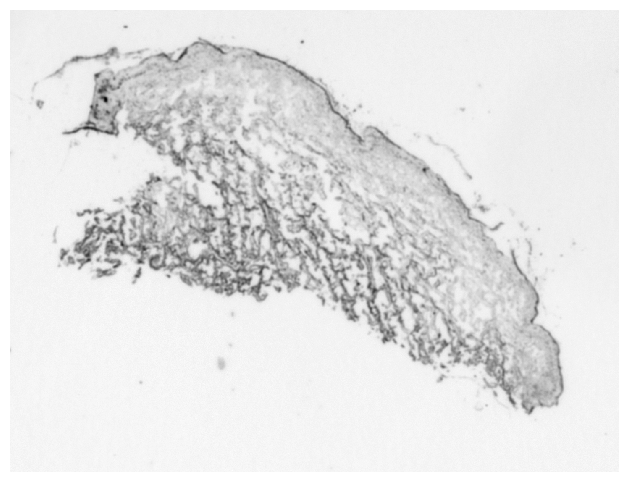

In [4]:
# Load and crop HH image
P15_HHraw_s = tiff.imread("K:\Eric Min_MMP\EricM_MMpolarimetry (CURRENTLY IN USE)\Polarimetry project MBP\Registered\April 3 2025\CEDS\P15\HH.tif")
P15_HH_s = np.array(P15_HHraw_s, dtype='long')  # use np.array instead of matrix
P15_HH_resized = P15_HH_s[300:1750, 500:1600]
P15_HH_rotated = np.rot90(P15_HH_resized, k=1)
# Display image
fig, ax = plt.subplots(figsize=(8,6))
img = ax.imshow(P15_HH_rotated, interpolation='nearest', cmap='gray')


# # Add scalebar (assume 0.5 microns per pixel)
# scalebar = ScaleBar(1.625, units="um", dimension="si-length", fixed_value=500, location='lower right', font_properties={"size": 12})
# ax.add_artist(scalebar)

# Optional: remove axes
ax.axis('off')
plt.show()


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[   0    0    0 ... 1346 1346 1346] [285 286 287 ... 543 544 545]


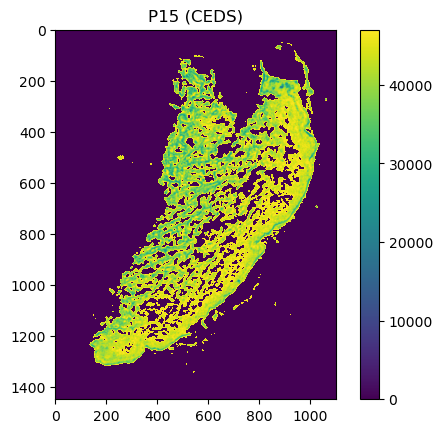

In [5]:
# Thresholding to remove background#
# Create the mask (vary threshold for every sample)
mask = P15_HH_resized < 47000

# Apply the mask
P15_HH_resized = np.where(mask, P15_HH_resized, 0)
valid_row_indices, valid_col_indices = np.nonzero(P15_HH_resized)

print(P15_HH_resized)
print(valid_row_indices, valid_col_indices)
plt.imshow(P15_HH_resized, interpolation='nearest') # Nearest interpolation for just resizing 
plt.colorbar() 
plt.title("P15 (CEDS)")
plt.show()

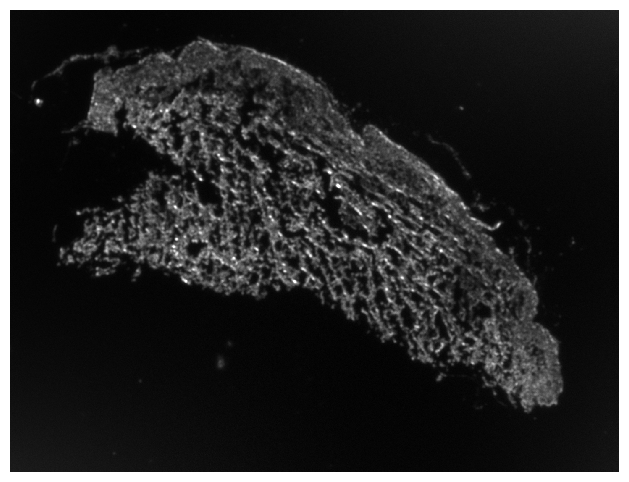

In [6]:
# Load and crop RL image #
P15_RLraw_s = tiff.imread("K:\Eric Min_MMP\EricM_MMpolarimetry (CURRENTLY IN USE)\Polarimetry project MBP\Registered\April 3 2025\CEDS\P15\RL.tif")
P15_RL_s = np.matrix(P15_RLraw_s, dtype='long')  # use 'long' for large values
P15_RL_resized = P15_RL_s[300:1750, 500:1600]    # cropping

# Rotate 90 degrees counter-clockwise
P15_RL_rotated = np.rot90(P15_RL_resized, k=1)

# Display image
fig, ax = plt.subplots(figsize=(8,6))
img = ax.imshow(P15_RL_rotated, interpolation='nearest', cmap='gray', vmax = 5000)

# # Add scalebar (assume 0.5 microns per pixel)
# scalebar = ScaleBar(1.625, units="um", dimension="si-length", fixed_value=500, location='lower right', font_properties={"size": 12})
# ax.add_artist(scalebar)

# Optional: remove axes
ax.axis('off')

plt.show()

In [7]:
# Preliminary cropping #
shape = np.shape(P15_HH_resized)

# Define the cropping parameters as constants --> apparently these are cropping parameters
CROP_Y_START = 300
CROP_Y_END = 1750
CROP_X_START = 500
CROP_X_END = 1600

In [8]:
# Step 1: Use the HH tissue mask (already thresholded)
# P15_HH_resized has been thresholded: values are 0 in background, >0 in tissue
tissue_mask = P15_HH_resized > 0  # Boolean mask, same shape as cropped images

# Step 2: Apply this mask to all images (preserve shape, zero background)
base_path = 'K:\\Eric Min_MMP\\EricM_MMpolarimetry (CURRENTLY IN USE)\\Polarimetry project MBP\\Registered\\April 3 2025\\CEDS\\P15\\blank\\'
labels = ['HH', 'HV', 'HP', 'HB', 'HR', 'HL', 'VH', 'VV', 'VP', 'VB', 'VR', 'VL', 'BH', 'BV', 'BP', 'BB', 'BR', 'BL', 'RH', 'RV', 'RP', 'RB', 'RR', 'RL']

P15_blanks = {}

for label in labels:
    filepath = f'{base_path}{label}.tif'
    data = tiff.imread(filepath)
    P15_blanks[f'P15_{label}_a'] = np.matrix(data, dtype='long')[CROP_Y_START:CROP_Y_END, CROP_X_START:CROP_X_END]
    P15_blanks[f'P15_{label}_a'] = np.where(tissue_mask, P15_blanks[f'P15_{label}_a'], 0)
    
P15_HH_a = P15_blanks['P15_HH_a']
P15_HV_a = P15_blanks['P15_HV_a']
P15_HP_a = P15_blanks['P15_HP_a']
P15_HB_a = P15_blanks['P15_HB_a']
P15_HR_a = P15_blanks['P15_HR_a']
P15_HL_a = P15_blanks['P15_HL_a']

P15_VH_a = P15_blanks['P15_VH_a']
P15_VV_a = P15_blanks['P15_VV_a']
P15_VP_a = P15_blanks['P15_VP_a']
P15_VB_a = P15_blanks['P15_VB_a']
P15_VR_a = P15_blanks['P15_VR_a']
P15_VL_a = P15_blanks['P15_VL_a']

P15_BH_a = P15_blanks['P15_BH_a']
P15_BV_a = P15_blanks['P15_BV_a']
P15_BP_a = P15_blanks['P15_BP_a']
P15_BB_a = P15_blanks['P15_BB_a']
P15_BR_a = P15_blanks['P15_BR_a']
P15_BL_a = P15_blanks['P15_BL_a']

P15_RH_a = P15_blanks['P15_RH_a']
P15_RV_a = P15_blanks['P15_RV_a']
P15_RP_a = P15_blanks['P15_RP_a']
P15_RB_a = P15_blanks['P15_RB_a']
P15_RR_a = P15_blanks['P15_RR_a']
P15_RL_a = P15_blanks['P15_RL_a']


In [9]:
# Get components of input Stokes vector #
H_in_15 = Stokes_dict_in(P15_HH_a, P15_HV_a, P15_HP_a, P15_HB_a, P15_HR_a, P15_HL_a)
H_Iin_15= np.array(H_in_15['Iin'])
H_Qin_15= np.array(H_in_15['Qin'])
H_Uin_15= np.array(H_in_15['Uin'])
H_Vin_15= np.array(H_in_15['Vin'])

B_in_15 = Stokes_dict_in(P15_BH_a, P15_BV_a, P15_BP_a, P15_BB_a, P15_BR_a, P15_BL_a)
B_Iin_15= np.array(B_in_15['Iin'])
B_Qin_15= np.array(B_in_15['Qin'])
B_Uin_15= np.array(B_in_15['Uin'])
B_Vin_15= np.array(B_in_15['Vin'])

V_in_15 = Stokes_dict_in(P15_VH_a, P15_VV_a, P15_VP_a, P15_VB_a, P15_VR_a, P15_VL_a)
V_Iin_15= np.array(V_in_15['Iin'])
V_Qin_15= np.array(V_in_15['Qin'])
V_Uin_15= np.array(V_in_15['Uin'])
V_Vin_15= np.array(V_in_15['Vin'])

R_in_15 = Stokes_dict_in(P15_RH_a, P15_RV_a, P15_RP_a, P15_RB_a, P15_RR_a, P15_RL_a)
R_Iin_15= np.array(R_in_15['Iin'])
R_Qin_15= np.array(R_in_15['Qin'])
R_Uin_15= np.array(R_in_15['Uin'])
R_Vin_15= np.array(R_in_15['Vin'])


In [10]:
# To extract the input Stokes vector 
Sin_15 = np.empty(shape, dtype=object)

for i in range(shape[0]):
    for j in range(shape[1]):
        if tissue_mask[i, j]:
            Sin_15[i][j] = np.array([
                [H_Iin_15[i][j], B_Iin_15[i][j], V_Iin_15[i][j], R_Iin_15[i][j]],
                [H_Qin_15[i][j], B_Qin_15[i][j], V_Qin_15[i][j], R_Qin_15[i][j]],
                [H_Uin_15[i][j], B_Uin_15[i][j], V_Uin_15[i][j], R_Uin_15[i][j]],
                [H_Vin_15[i][j], B_Vin_15[i][j], V_Vin_15[i][j], R_Vin_15[i][j]]
            ])
        else:
            Sin_15[i][j] = None

# Get inverse input Stokes vector for MM calculation

Sin_15_inv = np.empty(shape, dtype=object)

for i in range(shape[0]):
    for j in range(shape[1]):
        if tissue_mask[i, j]:
            try:
                Sin_15_inv[i][j] = np.linalg.inv(Sin_15[i][j])
            except np.linalg.LinAlgError:
                Sin_15_inv[i][j] = None  # Singular matrix
        else:
            Sin_15_inv[i][j] = None
            


In [11]:
# Sanity Check #
print(Sin_15)
print(Sin_15_inv)
non_none = [Sin_15_inv[i][j] for i in range(shape[0]) for j in range(shape[1]) if Sin_15_inv[i][j] is not None]
non_none_sin = [Sin_15[i][j] for i in range(shape[0]) for j in range(shape[1]) if Sin_15[i][j] is not None]
print(f"Number of invertible matrices (Sin_inv): {len(non_none)}")
print(f"Number of invertible matrices (Sin): {len(non_none_sin)}")


[[None None None ... None None None]
 [None None None ... None None None]
 [None None None ... None None None]
 ...
 [None None None ... None None None]
 [None None None ... None None None]
 [None None None ... None None None]]
[[None None None ... None None None]
 [None None None ... None None None]
 [None None None ... None None None]
 ...
 [None None None ... None None None]
 [None None None ... None None None]
 [None None None ... None None None]]
Number of invertible matrices (Sin_inv): 421546
Number of invertible matrices (Sin): 421546


In [12]:
# Process Images

# P15 DATA #

base_path ='K:\\Eric Min_MMP\\EricM_MMpolarimetry (CURRENTLY IN USE)\\Polarimetry project MBP\\Registered\\April 3 2025\\CEDS\\P15\\'
labels = ['HH', 'HV', 'HP', 'HB', 'HR', 'HL', 'VH', 'VV', 'VP', 'VB', 'VR', 'VL', 'BH', 'BV', 'BP', 'BB', 'BR', 'BL', 'RH', 'RV', 'RP', 'RB', 'RR', 'RL']

P15_images = {}

for label in labels:
    filepath = f'{base_path}{label}.tif'
    data = tiff.imread(filepath)
    P15_images[f'P15_{label}_s'] = np.matrix(data, dtype='long')[CROP_Y_START:CROP_Y_END, CROP_X_START:CROP_X_END]
    P15_images[f'P15_{label}_s'] = np.where(tissue_mask, P15_images[f'P15_{label}_s'], 0)
    
P15_HH_s = P15_images['P15_HH_s']
P15_HV_s = P15_images['P15_HV_s']
P15_HP_s = P15_images['P15_HP_s']
P15_HB_s = P15_images['P15_HB_s']
P15_HR_s = P15_images['P15_HR_s']
P15_HL_s = P15_images['P15_HL_s']

P15_VH_s = P15_images['P15_VH_s']
P15_VV_s = P15_images['P15_VV_s']
P15_VP_s = P15_images['P15_VP_s']
P15_VB_s = P15_images['P15_VB_s']
P15_VR_s = P15_images['P15_VR_s']
P15_VL_s = P15_images['P15_VL_s']

P15_BH_s = P15_images['P15_BH_s']
P15_BV_s = P15_images['P15_BV_s']
P15_BP_s = P15_images['P15_BP_s']
P15_BB_s = P15_images['P15_BB_s']
P15_BR_s = P15_images['P15_BR_s']
P15_BL_s = P15_images['P15_BL_s']

P15_RH_s = P15_images['P15_RH_s']
P15_RV_s = P15_images['P15_RV_s']
P15_RP_s = P15_images['P15_RP_s']
P15_RB_s = P15_images['P15_RB_s']
P15_RR_s = P15_images['P15_RR_s']
P15_RL_s = P15_images['P15_RL_s']



In [13]:
# Get components of output Stokes vector #

H_out_15 = Stokes_dict_out(P15_HH_s, P15_HV_s, P15_HP_s, P15_HB_s, P15_HR_s, P15_HL_s)
H_Iout_15= np.array(H_out_15['Iout'])
H_Qout_15= np.array(H_out_15['Qout'])
H_Uout_15= np.array(H_out_15['Uout'])
H_Vout_15= np.array(H_out_15['Vout'])

B_out_15 = Stokes_dict_out(P15_BH_s, P15_BV_s, P15_BP_s, P15_BB_s, P15_BR_s, P15_BL_s)
B_Iout_15= np.array(B_out_15['Iout'])
B_Qout_15= np.array(B_out_15['Qout'])
B_Uout_15= np.array(B_out_15['Uout'])
B_Vout_15= np.array(B_out_15['Vout'])

V_out_15 = Stokes_dict_out(P15_VH_s, P15_VV_s, P15_VP_s, P15_VB_s, P15_VR_s, P15_VL_s)
V_Iout_15= np.array(V_out_15['Iout'])
V_Qout_15= np.array(V_out_15['Qout'])
V_Uout_15= np.array(V_out_15['Uout'])
V_Vout_15= np.array(V_out_15['Vout'])

R_out_15 = Stokes_dict_out(P15_RH_s, P15_RV_s, P15_RP_s, P15_RB_s, P15_RR_s, P15_RL_s)
R_Iout_15= np.array(R_out_15['Iout'])
R_Qout_15= np.array(R_out_15['Qout'])
R_Uout_15= np.array(R_out_15['Uout'])
R_Vout_15= np.array(R_out_15['Vout'])


In [14]:
# To extract output Stokes vector #

Sout_15 = np.empty(shape, dtype=object)

for i in range(shape[0]):
    for j in range(shape[1]):
        if tissue_mask[i, j]:
            Sout_15[i][j] = np.array([
                [H_Iout_15[i][j], B_Iout_15[i][j], V_Iout_15[i][j], R_Iout_15[i][j]],
                [H_Qout_15[i][j], B_Qout_15[i][j], V_Qout_15[i][j], R_Qout_15[i][j]],
                [H_Uout_15[i][j], B_Uout_15[i][j], V_Uout_15[i][j], R_Uout_15[i][j]],
                [H_Vout_15[i][j], B_Vout_15[i][j], V_Vout_15[i][j], R_Vout_15[i][j]]
            ])
                
        else:
            Sout_15[i][j] = None


In [15]:
# Sanity Check #
print(Sout_15)
non_none_sout = [Sout_15[i][j] for i in range(shape[0]) for j in range(shape[1]) if Sout_15[i][j] is not None]
print(f"Number of invertible matrices (Sout): {len(non_none_sout)}")


[[None None None ... None None None]
 [None None None ... None None None]
 [None None None ... None None None]
 ...
 [None None None ... None None None]
 [None None None ... None None None]
 [None None None ... None None None]]
Number of invertible matrices (Sout): 421546


In [16]:
# Mueller matrix calculation using linear algebra library 
M_15 = np.empty(shape, dtype=object)

# replace Nones with identity matrices 
for i in range(shape[0]):
    for j in range(shape[1]):
        if Sout_15[i][j] is not None and Sin_15_inv[i][j] is not None:
            try:
                M_15[i][j] = np.matmul(Sout_15[i][j], Sin_15_inv[i][j])
            except Exception as e:
                M_15[i][j] = np.eye(4)  # or log e if needed
        else:
            M_15[i][j] = np.eye(4)


In [17]:
# Sanity Check #
print(M_15)
non_none_M = [M_15[i][j] for i in range(shape[0]) for j in range(shape[1]) if M_15[i][j] is not None]
print(f"Number of invertible matrices (M): {len(non_none_M)}")

[[array([[1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [0., 0., 1., 0.],
         [0., 0., 0., 1.]]) array([[1., 0., 0., 0.],
                                   [0., 1., 0., 0.],
                                   [0., 0., 1., 0.],
                                   [0., 0., 0., 1.]])
  array([[1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [0., 0., 1., 0.],
         [0., 0., 0., 1.]]) ... array([[1., 0., 0., 0.],
                                       [0., 1., 0., 0.],
                                       [0., 0., 1., 0.],
                                       [0., 0., 0., 1.]])
  array([[1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [0., 0., 1., 0.],
         [0., 0., 0., 1.]]) array([[1., 0., 0., 0.],
                                   [0., 1., 0., 0.],
                                   [0., 0., 1., 0.],
                                   [0., 0., 0., 1.]])]
 [array([[1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [0., 0., 1., 0.],
         [0., 0., 0.

In [18]:
# MM elements -- for each pixel 
M_15_00 = np.ndarray(shape, dtype = float)
M_15_01 = np.ndarray(shape, dtype = float)
M_15_02 = np.ndarray(shape, dtype = float)
M_15_03 = np.ndarray(shape, dtype = float)

M_15_10 = np.ndarray(shape, dtype = float)
M_15_11 = np.ndarray(shape, dtype = float)
M_15_12 = np.ndarray(shape, dtype = float)
M_15_13 = np.ndarray(shape, dtype = float)

M_15_20 = np.ndarray(shape, dtype = float)
M_15_21 = np.ndarray(shape, dtype = float)
M_15_22 = np.ndarray(shape, dtype = float)
M_15_23 = np.ndarray(shape, dtype = float)

M_15_30 = np.ndarray(shape, dtype = float)
M_15_31 = np.ndarray(shape, dtype = float)
M_15_32 = np.ndarray(shape, dtype = float)
M_15_33 = np.ndarray(shape, dtype = float)

for i in range(shape[0]):
    for j in range(shape[1]):
        
        M_15_00[i][j] = M_15[i][j][0][0]
        M_15_01[i][j] = M_15[i][j][0][1]
        M_15_02[i][j] = M_15[i][j][0][2]
        M_15_03[i][j] = M_15[i][j][0][3]
        
        M_15_10[i][j] = M_15[i][j][1][0]
        M_15_11[i][j] = M_15[i][j][1][1]
        M_15_12[i][j] = M_15[i][j][1][2]
        M_15_13[i][j] = M_15[i][j][1][3]
        
        M_15_20[i][j] = M_15[i][j][2][0]
        M_15_21[i][j] = M_15[i][j][2][1]
        M_15_22[i][j] = M_15[i][j][2][2]
        M_15_23[i][j] = M_15[i][j][2][3]
        
        M_15_30[i][j] = M_15[i][j][3][0]
        M_15_31[i][j] = M_15[i][j][3][1]
        M_15_32[i][j] = M_15[i][j][3][2]
        M_15_33[i][j] = M_15[i][j][3][3]




In [19]:
# Sanity Check #
print(M_15_11)
print(M_15_11.shape)
non_one_M_00 = [M_15_11[i][j] for i in range(shape[0]) for j in range(shape[1]) if M_15_11[i][j] != 1]
print(f"Number of non-identity matrices (M00): {len(non_one_M_00)}")

[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]
(1450, 1100)
Number of non-identity matrices (M00): 421546


In [20]:

# Obtain MM elements mean, median, standard deviations, kurtosis, skew#

avg_M_15_00, med_M_15_00, std_M_15_00, kurt_M_15_00, skew_M_15_00 = parameter_stats(M_15_00, tissue_mask)
avg_M_15_01, med_M_15_01, std_M_15_01, kurt_M_15_01, skew_M_15_01 = parameter_stats(M_15_01, tissue_mask)
avg_M_15_02, med_M_15_02, std_M_15_02, kurt_M_15_02, skew_M_15_02 = parameter_stats(M_15_02, tissue_mask)
avg_M_15_03, med_M_15_03, std_M_15_03, kurt_M_15_03, skew_M_15_03 = parameter_stats(M_15_03, tissue_mask)

avg_M_15_10, med_M_15_10, std_M_15_10, kurt_M_15_10, skew_M_15_10 = parameter_stats(M_15_10, tissue_mask)
avg_M_15_11, med_M_15_11, std_M_15_11, kurt_M_15_11, skew_M_15_11 = parameter_stats(M_15_11, tissue_mask)
avg_M_15_12, med_M_15_12, std_M_15_12, kurt_M_15_12, skew_M_15_12 = parameter_stats(M_15_12, tissue_mask)
avg_M_15_13, med_M_15_13, std_M_15_13, kurt_M_15_13, skew_M_15_13 = parameter_stats(M_15_13, tissue_mask)

avg_M_15_20, med_M_15_20, std_M_15_20, kurt_M_15_20, skew_M_15_20 = parameter_stats(M_15_20, tissue_mask)
avg_M_15_21, med_M_15_21, std_M_15_21, kurt_M_15_21, skew_M_15_21 = parameter_stats(M_15_21, tissue_mask)
avg_M_15_22, med_M_15_22, std_M_15_22, kurt_M_15_22, skew_M_15_22 = parameter_stats(M_15_22, tissue_mask)
avg_M_15_23, med_M_15_23, std_M_15_23, kurt_M_15_23, skew_M_15_23 = parameter_stats(M_15_23, tissue_mask)

avg_M_15_30, med_M_15_30, std_M_15_30, kurt_M_15_30, skew_M_15_30 = parameter_stats(M_15_30, tissue_mask)
avg_M_15_31, med_M_15_31, std_M_15_31, kurt_M_15_31, skew_M_15_31 = parameter_stats(M_15_31, tissue_mask)
avg_M_15_32, med_M_15_32, std_M_15_32, kurt_M_15_32, skew_M_15_32 = parameter_stats(M_15_32, tissue_mask)
avg_M_15_33, med_M_15_33, std_M_15_33, kurt_M_15_33, skew_M_15_33 = parameter_stats(M_15_33, tissue_mask)




In [21]:
print(med_M_15_00)
print(avg_M_15_00)
print(std_M_15_00)
print(kurt_M_15_00)
print(skew_M_15_00)
print('-------------------------------------')
print(med_M_15_32)
print(avg_M_15_32)
print(std_M_15_32)
print(kurt_M_15_32)
print(skew_M_15_32)

0.7953474994850591
0.7743190776826492
0.07692469430530798
0.7053007030347764
-1.0618772874027507
-------------------------------------
0.0017053354177101485
0.001585161413779845
0.009676310550518142
6.167644000755791
-0.1452472268594835


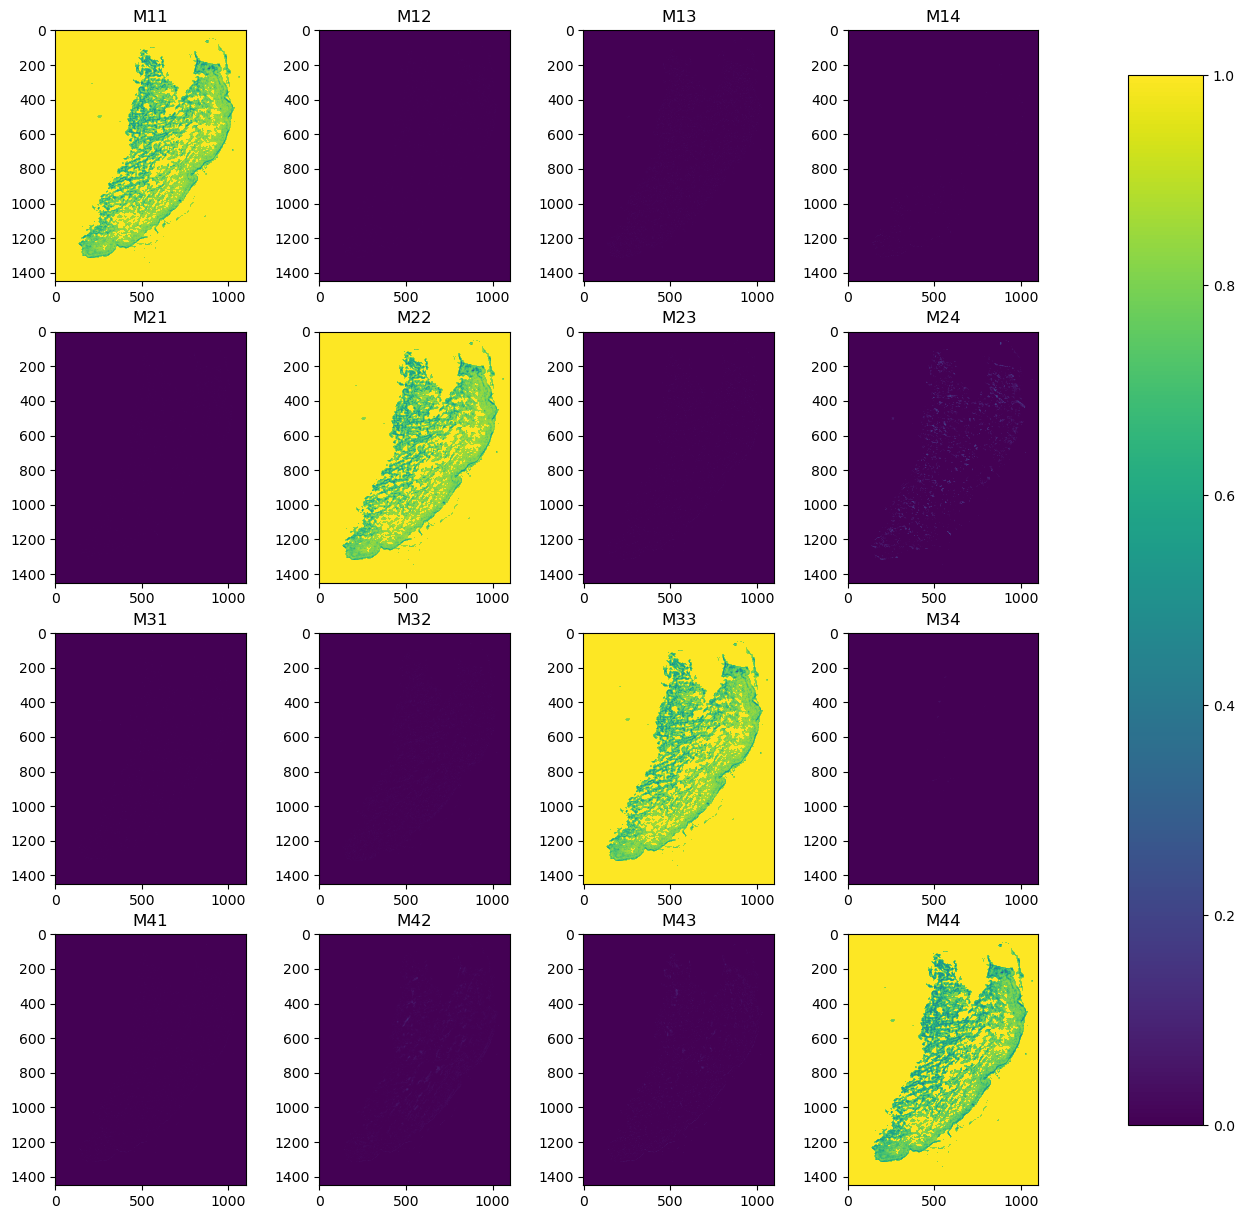

In [22]:
from matplotlib import cm
fig, axs = plt.subplots(4, 4, figsize=(15,15))
for ax in axs.flat:
    im1 = axs[0, 0].imshow(M_15_00, interpolation='nearest',cmap=plt.cm.viridis, vmin=0, vmax=1)
    t1 = axs[0, 0].set_title('M11')
    im2 = axs[0, 1].imshow(M_15_01, interpolation='nearest',cmap=plt.cm.viridis, vmin=0, vmax=1)
    t2 = axs[0, 1].set_title('M12')
    im3 = axs[0, 2].imshow(M_15_02, interpolation='nearest',cmap=plt.cm.viridis, vmin=0, vmax=1)
    t3 = axs[0, 2].set_title('M13')
    im4= axs[0, 3].imshow(M_15_03, interpolation='nearest',cmap=plt.cm.viridis, vmin=0, vmax=1)
    t4 = axs[0, 3].set_title('M14')
    im5 = axs[1, 0].imshow(M_15_10, interpolation='nearest',cmap=plt.cm.viridis, vmin=0, vmax=1)
    t5 = axs[1, 0].set_title('M21')
    im6 = axs[1, 1].imshow(M_15_11, interpolation='nearest',cmap=plt.cm.viridis, vmin=0, vmax=1)
    t6 = axs[1, 1].set_title('M22')
    im7 = axs[1, 2].imshow(M_15_12, interpolation='nearest',cmap=plt.cm.viridis, vmin=0, vmax=1)
    t7 = axs[1, 2].set_title('M23')
    im8 = axs[1, 3].imshow(M_15_13, interpolation='nearest',cmap=plt.cm.viridis, vmin=0, vmax=1)
    t8 = axs[1, 3].set_title('M24')
    im9 = axs[2, 0].imshow(M_15_20, interpolation='nearest',cmap=plt.cm.viridis, vmin=0, vmax=1)
    t9 = axs[2, 0].set_title('M31')
    im10 = axs[2, 1].imshow(M_15_21, interpolation='nearest',cmap=plt.cm.viridis, vmin=0, vmax=1)
    t10 = axs[2, 1].set_title('M32')
    im11 = axs[2, 2].imshow(M_15_22, interpolation='nearest',cmap=plt.cm.viridis, vmin=0, vmax=1)
    t11 = axs[2, 2].set_title('M33')
    im12 = axs[2, 3].imshow(M_15_23, interpolation='nearest',cmap=plt.cm.viridis, vmin=0, vmax=1)
    t12 = axs[2, 3].set_title('M34')
    im13 = axs[3, 0].imshow(M_15_30, interpolation='nearest',cmap=plt.cm.viridis, vmin=0, vmax=1)
    t13 = axs[3, 0].set_title('M41')
    im14 = axs[3, 1].imshow(M_15_31, interpolation='nearest',cmap=plt.cm.viridis, vmin=0, vmax=1)
    t14 = axs[3, 1].set_title('M42')
    im15 = axs[3, 2].imshow(M_15_32, interpolation='nearest',cmap=plt.cm.viridis, vmin=0, vmax=1)
    t15 = axs[3, 2].set_title('M43')
    im16 = axs[3, 3].imshow(M_15_33, interpolation='nearest',cmap=plt.cm.viridis, vmin=0, vmax=1)
    t16 = axs[3, 3].set_title('M44')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im1, cax=cbar_ax)


plt.show()


In [23]:
 # LU CHIPMAN POLAR DECOMPOSITION #

In [24]:
# Assuming HH_resized is your cropped or sliced image array
dimensions_15 = P15_HH_resized.shape

# dimensions will be a tuple like (height, width)
height_15, width_15 = dimensions_15

print("Height:", height_15)
print("Width:", width_15)

Height: 1450
Width: 1100


In [25]:
# Total Retardance #
Meller_matrix_15 = np.ndarray((height_15, width_15), dtype = object)
LuCh_15 = np.ndarray((height_15, width_15), dtype = object)
Mdepol_15 = np.ndarray((height_15, width_15), dtype = object)  # Depolarizer matrix
Mret_15 = np.ndarray((height_15, width_15), dtype = object)   # Retarder matrix
Mdiatten_15 = np.ndarray((height_15, width_15), dtype = object)   # Diattenuator matrix
T_15 = np.ndarray((height_15, width_15), dtype = float)  
Retardance_15 = np.ndarray((height_15, width_15), dtype = float)

for k in range(height_15):
    for m in range(width_15):
        Meller_matrix_15[k][m] = MuellerMatrix(M_15[k][m]) 
        LuCh_15[k][m] = Lu_Chipman_Decomposition(Meller_matrix_15[k][m])
        Mdepol_15[k][m], Mret_15[k][m], Mdiatten_15[k][m] = LuCh_15[k][m] 
        T_15[k][m] = np.trace(Mret_15[k][m])/2-1
        if T_15[k][m] > 1:
            Retardance_15[k][m] = math.acos(1)  # there are values >1 and < -1
        elif T_15[k][m] < -1:
            Retardance_15[k][m] = math.acos(1)  # mathematically it's 180˚ but physically 0˚
        else:
            Retardance_15[k][m] = math.acos(T_15[k][m])



In [26]:
# Linear retardance #

LinearRetardance_15 = np.ndarray((height_15, width_15), dtype=float)
values_before_acos_15 = np.ndarray((height_15, width_15), dtype=float)  # Array to store the values before acos

for k in range(height_15):
    for m in range(width_15):
        Meller_matrix_15[k][m] = MuellerMatrix(M_15[k][m]) 
        LuCh_15[k][m] = Lu_Chipman_Decomposition(Meller_matrix_15[k][m])
        Mdepol_15[k][m], Mret_15[k][m], Mdiatten_15[k][m] = LuCh_15[k][m]
        
        # Calculate the value for acos
        temp_value = (Mret_15[k][m][1][1] + Mret_15[k][m][2][2])**2 + (Mret_15[k][m][2][1] - Mret_15[k][m][1][2])**2
        temp_value = math.sqrt(temp_value) - 1

        # Clamp the value to be within [-1, 1]
        clamped_value = max(min(temp_value, 1), -1)
        
        # Store the clamped value
        values_before_acos_15[k][m] = clamped_value

        # Calculate the Linear Retardance
        LinearRetardance_15[k][m] = math.acos(clamped_value)



In [27]:
# Mueller matrix polar decomposition (MMPD) parameters
Md_15 = np.ndarray((height_15, width_15), dtype = float)
Depol_15 = np.ndarray((height_15, width_15), dtype = float)
opt_rot_15 = np.ndarray((height_15, width_15), dtype = float)

for k in range(height_15):
    for m in range(width_15):
        Meller_matrix_15[k][m] = MuellerMatrix(M_15[k][m]) 
        LuCh_15[k][m] = Lu_Chipman_Decomposition(Meller_matrix_15[k][m])
        Mdepol_15[k][m], Mret_15[k][m], Mdiatten_15[k][m] = LuCh_15[k][m]
    

        # Depolarization
#         Md[k][m] = Mdepol[k][m]-1
        Depol_15[k][m] = 1 - abs(((Mdepol_15[k][m]-1).trace()))/3
        Depolarization = pd.DataFrame(Depol_15)
        
        # Optical Rotation (had "-" in the denominator)
        phi = math.atan((Mret_15[k][m][2][1]-Mret_15[k][m][1][2])/(Mret_15[k][m][1][1]+Mret_15[k][m][2][2]))
        opt_rot_15[k][m] = np.where(phi < -np.pi/4, phi + np.pi/4, phi) # limit range to -pi/4 and pi/4 as defined

# OBTAIN STATS #
avg_Depol_15, med_Depol_15, std_Depol_15, kurt_Depol_15, skew_Depol_15 = parameter_stats(Depol_15, tissue_mask)
avg_opt_rot_15, med_opt_rot_15, std_opt_rot_15, kurt_opt_rot_15, skew_opt_rot_15 = parameter_stats(opt_rot_15, tissue_mask)



In [28]:
# Retardance, Linear Retardance in degree 
deg_ret_15 = np.ndarray((height_15, width_15), dtype = float)
deg_l_ret_15 = np.ndarray((height_15, width_15), dtype = float)
# Diattenuation 
diattenuation_15 = np.ndarray((height_15, width_15), dtype = float)

for k in range(height_15):
    for m in range(width_15):
        deg_ret_15[k][m] = math.degrees(Retardance_15[k][m])
        deg_l_ret_15[k][m] = math.degrees(LinearRetardance_15[k][m])
        diattenuation_15[k][m] = (math.sqrt(M_15[k][m][0][1]**2+M_15[k][m][0][2]**2+M_15[k][m][0][3]**2)) 

# OBTAIN STATS #
avg_deg_ret_15, med_deg_ret_15, std_deg_ret_15, kurt_deg_ret_15, skew_deg_ret_15 = parameter_stats(deg_ret_15, tissue_mask)
avg_deg_l_ret_15, med_deg_l_ret_15, std_deg_l_ret_15, kurt_deg_l_ret_15, skew_deg_l_ret_15 = parameter_stats(deg_l_ret_15, tissue_mask)
avg_diattenuation_15, med_diattenuation_15, std_diattenuation_15, kurt_diattenuation_15, skew_diattenuation_15 = parameter_stats(diattenuation_15, tissue_mask)

In [29]:
########### Mueller matrix transformation parameters (MMT) ###########
A_15 = np.ndarray((height_15, width_15), dtype = float)
b_15 = np.ndarray((height_15, width_15), dtype = float)
anisotropy_degree_15 = np.ndarray((height_15, width_15), dtype = float)
beta_15 = np.ndarray((height_15, width_15), dtype = float)

########### Mueller matrix rotation invariant parameters (MMRI) ###########
q_L_15 = np.ndarray((height_15, width_15), dtype = float) 
circular_to_linear_15 = np.ndarray((height_15, width_15), dtype = float) 
Linear_polar_15 = np.ndarray((height_15, width_15), dtype = float) 
Linear_diat_15 = np.ndarray((height_15, width_15), dtype = float) 
x_15 = np.ndarray((height_15, width_15), dtype = float) # Negated in paper due to bimodal distribution of results
# Dc is given by m14 and Pc by m41

# Calculated in one loop 
for k in range(height_15):
    for m in range(width_15):
        b_15[k][m] = (M_15[k][m][1][1]+M_15[k][m][2][2])/2  # Polarizance
        anisotropy_degree_15[k][m] = math.sqrt((M_15[k][m][1][1]-M_15[k][m][2][2])**2+(M_15[k][m][1][2]+M_15[k][m][2][1])**2)/2   # Anisotropy degree 
        A_15[k][m] = 2*b_15[k][m]*anisotropy_degree_15[k][m]/(b_15[k][m]**2+anisotropy_degree_15[k][m]**2) # Normalized anisotropy 
        q_L_15[k][m] = math.sqrt((M_15[k][m][3][1])**2+(M_15[k][m][3][2])**2)  # capability of transforming from linear to circular polarizations
        if M_15[k][m][0][1] == 0:
            theta = 0
        else:
            theta = (math.atan(M_15[k][m][0][2]/M_15[k][m][0][1]))/2
        x_15[k][m] = np.where(theta < -np.pi/4, theta + np.pi/4, theta)  
        circular_to_linear_15[k][m] = math.sqrt((M_15[k][m][1][3])**2+(M_15[k][m][2][3])**2) # capability of transforming from circular to linear polarizations
        Linear_polar_15[k][m] = math.sqrt((M_15[k][m][1][0])**2+(M_15[k][m][2][0])**2) # Linear polarizance (same as p_L)
        Linear_diat_15[k][m] = math.sqrt((M_15[k][m][0][1])**2+(M_15[k][m][0][2])**2) # Linear diattenuation
        beta_15[k][m] = abs(M_15[k][m][1][2] - M_15[k][m][2][1])/2  # circular birefringence 

        
# PARAMETER STATS #
avg_beta_15, med_beta_15, std_beta_15, kurt_beta_15, skew_beta_15 = parameter_stats(beta_15, tissue_mask)
avg_anisotropy_degree_15, med_anisotropy_degree_15, std_anisotropy_degree_15, kurt_anisotropy_degree_15, skew_anisotropy_degree_15 = parameter_stats(anisotropy_degree_15, tissue_mask)
avg_b_15, med_b_15, std_b_15, kurt_b_15, skew_b_15 = parameter_stats(b_15, tissue_mask)
avg_A_15, med_A_15, std_A_15, kurt_A_15, skew_A_15 = parameter_stats(A_15, tissue_mask)
avg_x_15, med_x_15, std_x_15, kurt_x_15, skew_x_15 = parameter_stats(x_15, tissue_mask)
avg_q_L_15, med_q_L_15, std_q_L_15, kurt_q_L_15, skew_q_L_15 = parameter_stats(q_L_15, tissue_mask)
avg_circular_to_linear_15, med_circular_to_linear_15, std_circular_to_linear_15, kurt_circular_to_linear_15, skew_circular_to_linear_15 = parameter_stats(circular_to_linear_15, tissue_mask)
avg_Linear_polar_15, med_Linear_polar_15, std_Linear_polar_15, kurt_Linear_polar_15, skew_Linear_polar_15 = parameter_stats(Linear_polar_15, tissue_mask)
avg_Linear_diat_15, med_Linear_diat_15, std_Linear_diat_15, kurt_Linear_diat_15, skew_Linear_diat_15 = parameter_stats(Linear_diat_15, tissue_mask)


In [30]:
# MMLI parameters
p_L_15 = np.ndarray((height_15, width_15), dtype = float)
p_1_15 = np.ndarray((height_15, width_15), dtype = float)
p_2_15 = np.ndarray((height_15, width_15), dtype = float)
p_3_15 = np.ndarray((height_15, width_15), dtype = float)
p_4_15 = np.ndarray((height_15, width_15), dtype = float)
p_5_15 = np.ndarray((height_15, width_15), dtype = float)
p_6_15 = np.ndarray((height_15, width_15), dtype = float)
p_7_15 = np.ndarray((height_15, width_15), dtype = float)
p_8_15 = np.ndarray((height_15, width_15), dtype = float)
p_tms_15 = np.ndarray((height_15, width_15), dtype = float)

for k in range(height_15):
    for m in range(width_15):
        p_L_15[k][m] = math.sqrt((M_15[k][m][1][0])**2+(M_15[k][m][2][0])**2)
        
        p_1_15[k][m] = (M_15[k][m][3][2]+M_15[k][m][2][3])/2
        
        p_2_15[k][m] = (M_15[k][m][3][1]+M_15[k][m][1][3])/2
        
        p_3_15[k][m] = abs(circular_to_linear_15[k][m]-q_L_15[k][m])
        
        p_4_15[k][m] = ((M_15[k][m][2][3]*M_15[k][m][1][3])-(M_15[k][m][3][1]*M_15[k][m][3][2]))/2
        
        p_5_15[k][m] = (M_15[k][m][0][1]-M_15[k][m][1][0])/2 
        
        p_6_15[k][m] = (M_15[k][m][0][2]-M_15[k][m][2][0])/3   
        
        p_7_15[k][m] = abs(Linear_diat_15[k][m]-p_L_15[k][m])
        
        p_8_15[k][m] = ((M_15[k][m][0][1]*M_15[k][m][0][2])-(M_15[k][m][1][0]*M_15[k][m][2][0]))/2
        
        p_tms_15[k][m] = math.sqrt((p_1_15[k][m])**2 + (p_2_15[k][m])**2)
        

# STATS #
avg_p_L_15, med_p_L_15, std_p_L_15, kurt_p_L_15, skew_p_L_15 = parameter_stats(p_L_15, tissue_mask)
avg_p_1_15, med_p_1_15, std_p_1_15, kurt_p_1_15, skew_p_1_15 = parameter_stats(p_1_15, tissue_mask)
avg_p_2_15, med_p_2_15, std_p_2_15, kurt_p_2_15, skew_p_2_15 = parameter_stats(p_2_15, tissue_mask)
avg_p_3_15, med_p_3_15, std_p_3_15, kurt_p_3_15, skew_p_3_15 = parameter_stats(p_3_15, tissue_mask)
avg_p_4_15, med_p_4_15, std_p_4_15, kurt_p_4_15, skew_p_4_15 = parameter_stats(p_4_15, tissue_mask)
avg_p_5_15, med_p_5_15, std_p_5_15, kurt_p_5_15, skew_p_5_15 = parameter_stats(p_5_15, tissue_mask)
avg_p_6_15, med_p_6_15, std_p_6_15, kurt_p_6_15, skew_p_6_15 = parameter_stats(p_6_15, tissue_mask)
avg_p_7_15, med_p_7_15, std_p_7_15, kurt_p_7_15, skew_p_7_15 = parameter_stats(p_7_15, tissue_mask)
avg_p_8_15, med_p_8_15, std_p_8_15, kurt_p_8_15, skew_p_8_15 = parameter_stats(p_8_15, tissue_mask)
avg_p_tms_15, med_p_tms_15, std_p_tms_15, kurt_p_tms_15, skew_p_tms_15 = parameter_stats(p_tms_15, tissue_mask)




In [31]:
# # CREATE NEW FILE (comment out after running once)#
# df_empty = pd.DataFrame({'Sample':[],
#                     'Status': [],
#                     'M11 (median)': [], 
#                     'M11 (mean)': [],
#                     'M11 (std)': [],
#                     'M11 (kurtosis)' :[],
#                     'M11 (skew)' :[],
#                     'M12 (median)': [],
#                     'M12 (mean)': [],
#                     'M12 (std)': [],
#                     'M12 (kurtosis)' :[],
#                     'M12 (skew)' :[],
#                     'M13 (median)': [],
#                     'M13 (mean)': [],
#                     'M13 (std)': [],
#                     'M13 (kurtosis)' :[],
#                     'M13 (skew)' :[],
#                     'M14 (median)': [],
#                     'M14 (mean)': [],
#                     'M14 (std)': [],
#                     'M14 (kurtosis)' :[],
#                     'M14 (skew)' :[],
#                     'M21 (median)': [],
#                     'M21 (mean)': [],
#                     'M21 (std)': [],
#                     'M21 (kurtosis)' :[],
#                     'M21 (skew)' :[],
#                     'M22 (median)': [],
#                     'M22 (mean)': [],
#                     'M22 (std)': [],
#                     'M22 (kurtosis)' :[],
#                     'M22 (skew)' :[],
#                     'M23 (median)': [],
#                     'M23 (mean)': [],
#                     'M23 (std)': [],
#                     'M23 (kurtosis)' :[],
#                     'M23 (skew)' :[],
#                     'M24 (median)': [],
#                     'M24 (mean)': [],
#                     'M24 (std)': [],
#                     'M24 (kurtosis)' :[],
#                     'M24 (skew)' :[],
#                     'M31 (median)': [],
#                     'M31 (mean)': [],
#                     'M31 (std)': [],
#                     'M31 (kurtosis)' :[],
#                     'M31 (skew)' :[],
#                     'M32 (median)': [],
#                     'M32 (mean)': [],
#                     'M32 (std)': [],
#                     'M32 (kurtosis)' :[],
#                     'M32 (skew)' :[],
#                     'M33 (median)': [],
#                     'M33 (mean)': [],
#                     'M33 (std)': [],
#                     'M33 (kurtosis)' :[],
#                     'M33 (skew)' :[],
#                     'M34 (median)': [],
#                     'M34 (mean)': [],
#                     'M34 (std)': [],
#                     'M34 (kurtosis)' :[],
#                     'M34 (skew)' :[],
#                     'M41 (median)': [],
#                     'M41 (mean)': [],
#                     'M41 (std)': [],
#                     'M41 (kurtosis)' :[],
#                     'M41 (skew)' :[],
#                     'M42 (median)': [],
#                     'M42 (mean)': [],
#                     'M42 (std)': [],
#                     'M42 (kurtosis)' :[],
#                     'M42 (skew)' :[],
#                     'M43 (median)': [],
#                     'M43 (mean)': [],
#                     'M43 (std)': [],
#                     'M43 (kurtosis)' :[],
#                     'M43 (skew)' :[],
#                     'M44 (median)': [],
#                     'M44 (mean)': [],
#                     'M44 (std)': [],
#                     'M44 (kurtosis)' :[],
#                     'M44 (skew)' :[],
#                     'Retardance (median)':[],
#                     'Retardance (mean)':[],
#                     'Retardance (std)':[],
#                     'Retardance (kurtosis)':[],
#                     'Retardance (skew)':[],
#                     'Linear Retardance (median)':[],
#                     'Linear Retardance (mean)':[],
#                     'Linear Retardance (std)':[],
#                     'Linear Retardance (kurtosis)':[],
#                     'Linear Retardance (skew)':[],
#                     'Diattenuation (median)':[],
#                     'Diattenuation (mean)':[],
#                     'Diattenuation (std)':[],
#                     'Diattenuation (kurtosis)':[],
#                     'Diattenuation (skew)':[],
#                     'Depolarization (median)': [],
#                     'Depolarization (mean)': [],
#                     'Depolarization (std)': [],
#                     'Depolarization (kurtosis)': [],
#                     'Depolarization (skew)': [],
#                     'A (median)': [],
#                     'A (mean)': [],
#                     'A (std)': [],
#                     'A (kurtosis)': [],
#                     'A (skew)': [],
#                     'b (median)':[],
#                     'b (mean)':[],
#                     'b (std)':[],
#                     'b (kurtosis)':[],
#                     'b (skew)':[],
#                     'Anisotropy degree (median)':[],
#                     'Anisotropy degree (mean)':[],
#                     'Anisotropy degree (std)':[],
#                     'Anisotropy degree (kurtosis)':[],
#                     'Anisotropy degree (skew)':[],
#                     'q_L (median)':[],
#                     'q_L (mean)':[],
#                     'q_L (std)':[],
#                     'q_L (kurtosis)':[],
#                     'q_L (skew)':[],
#                     "x (median)": [],
#                     "x (mean)": [], 
#                     "x (std)": [],
#                     "x (kurtosis)": [], 
#                     "x (skew)": [],
#                     "circular_to_linear (median)":[],
#                     "circular_to_linear (mean)":[],
#                     "circular_to_linear (std)":[],
#                     "circular_to_linear (kurtosis)":[],
#                     "circular_to_linear (skew)":[],
#                     "Linear_polar (median)":[],
#                     "Linear_polar (mean)":[], 
#                     "Linear_polar (std)":[],
#                     "Linear_polar (kurtosis)":[], 
#                     "Linear_polar (skew)":[],
#                     "Linear_diat (median)":[],
#                     "Linear_diat (mean)":[],
#                     "Linear_diat (std)":[],
#                     "Linear_diat (kurtosis)":[],
#                     "Linear_diat (skew)":[],
#                     "beta (median)":[],
#                     "beta (mean)":[],
#                     "beta (std)":[],
#                      "beta (kurtosis)":[],
#                     "beta (skew)":[],
#                     "opt_rot (median)":[], 
#                     "opt_rot (mean)":[], 
#                     "opt_rot (std)":[],
#                     "opt_rot (kurtosis)":[], 
#                     "opt_rot (skew)":[],
#                     "p_L (median)":[], 
#                     "p_L (mean)":[], 
#                     "p_L (std)":[],
#                     "p_L (kurtosis)":[], 
#                     "p_L (skew)":[],
#                     "p_1 (median)":[], 
#                     "p_1 (mean)":[],
#                     "p_1 (std)":[],
#                     "p_1 (kurtosis)":[],
#                     "p_1 (skew)":[],
#                     "p_2 (median)":[],
#                     "p_2 (mean)":[], 
#                     "p_2 (std)":[],
#                     "p_2 (kurtosis)":[], 
#                     "p_2 (skew)":[],
#                     "p_3 (median)":[], 
#                     "p_3 (mean)":[], 
#                     "p_3 (std)":[],
#                     "p_3 (kurtosis)":[], 
#                     "p_3 (skew)":[],
#                     "p_4 (median)":[], 
#                     "p_4 (mean)":[], 
#                     "p_4 (std)":[],
#                     "p_4 (kurtosis)":[], 
#                     "p_4 (skew)":[],
#                     "p_5 (median)":[], 
#                     "p_5 (mean)":[], 
#                     "p_5 (std)":[],
#                     "p_5 (kurtosis)":[], 
#                     "p_5 (skew)":[],
#                     "p_6 (median)":[], 
#                     "p_6 (mean)":[], 
#                     "p_6 (std)":[],
#                     "p_6 (kurtosis)":[], 
#                     "p_6 (skew)":[],
#                     "p_7 (median)":[],
#                     "p_7 (mean)":[],
#                     "p_7 (std)":[],
#                     "p_7 (kurtosis)":[],
#                     "p_7 (skew)":[],
#                     "p_8 (median)":[], 
#                     "p_8 (mean)":[], 
#                     "p_8 (std)":[],
#                     "p_8 (kurtosis)":[], 
#                     "p_8 (skew)":[],
#                     "p_tms (median)":[],
#                     "p_tms (mean)":[],
#                     "p_tms (std)":[],
#                     "p_tms (kurtosis)":[],
#                     "p_tms (skew)":[]})

# # determining the name of the file
# file_name = 'K:\\Eric Min_MMP\\EricM_MMpolarimetry (CURRENTLY IN USE)\\Polarimetry project MBP\\stats_master.xlsx'

# # saving the excel
# df_empty.to_excel(file_name)
# print('DataFrame is written to Excel File successfully.')



In [32]:
# LOADING OF DATA INTO EXCEL #
df_15 = pd.DataFrame({'Sample':['P15'],
                    'Status': ['CEDS'],
                    'M11 (median)': [med_M_15_00], 
                    'M11 (mean)': [avg_M_15_00],
                    'M11 (std)': [std_M_15_00],
                    'M11 (kurtosis)' :[kurt_M_15_00],
                    'M11 (skew)' :[skew_M_15_00],
                    'M12 (median)': [med_M_15_01],
                    'M12 (mean)': [avg_M_15_01],
                    'M12 (std)': [std_M_15_01],
                    'M12 (kurtosis)' :[kurt_M_15_01],
                    'M12 (skew)' :[skew_M_15_01],
                    'M13 (median)': [med_M_15_02],
                    'M13 (mean)': [avg_M_15_02],
                    'M13 (std)': [std_M_15_02],
                    'M13 (kurtosis)' :[kurt_M_15_02],
                    'M13 (skew)' :[skew_M_15_02],
                    'M14 (median)': [med_M_15_03],
                    'M14 (mean)': [avg_M_15_03],
                    'M14 (std)': [std_M_15_03],
                    'M14 (kurtosis)' :[kurt_M_15_03],
                    'M14 (skew)' :[skew_M_15_03],
                    'M21 (median)': [med_M_15_10],
                    'M21 (mean)': [avg_M_15_10],
                    'M21 (std)': [std_M_15_10],
                    'M21 (kurtosis)' :[kurt_M_15_10],
                    'M21 (skew)' :[skew_M_15_10],
                    'M22 (median)': [med_M_15_11],
                    'M22 (mean)': [avg_M_15_11],
                    'M22 (std)': [std_M_15_11],
                    'M22 (kurtosis)' :[kurt_M_15_11],
                    'M22 (skew)' :[skew_M_15_11],
                    'M23 (median)': [med_M_15_12],
                    'M23 (mean)': [avg_M_15_12],
                    'M23 (std)': [std_M_15_12],
                    'M23 (kurtosis)' :[kurt_M_15_12],
                    'M23 (skew)' :[skew_M_15_12],
                    'M24 (median)': [med_M_15_13],
                    'M24 (mean)': [avg_M_15_13],
                    'M24 (std)': [std_M_15_13],
                    'M24 (kurtosis)' :[kurt_M_15_13],
                    'M24 (skew)' :[skew_M_15_13],
                    'M31 (median)': [med_M_15_20],
                    'M31 (mean)': [avg_M_15_20],
                    'M31 (std)': [std_M_15_20],
                    'M31 (kurtosis)' :[kurt_M_15_20],
                    'M31 (skew)' :[skew_M_15_20],
                    'M32 (median)': [med_M_15_21],
                    'M32 (mean)': [avg_M_15_21],
                    'M32 (std)': [std_M_15_21],
                    'M32 (kurtosis)' :[kurt_M_15_21],
                    'M32 (skew)' :[skew_M_15_21],
                    'M33 (median)': [med_M_15_22],
                    'M33 (mean)': [avg_M_15_22],
                    'M33 (std)': [std_M_15_22],
                    'M33 (kurtosis)' :[kurt_M_15_22],
                    'M33 (skew)' :[skew_M_15_22],
                    'M34 (median)': [med_M_15_23],
                    'M34 (mean)': [avg_M_15_23],
                    'M34 (std)': [std_M_15_23],
                    'M34 (kurtosis)' :[kurt_M_15_23],
                    'M34 (skew)' :[skew_M_15_23],
                    'M41 (median)': [med_M_15_30],
                    'M41 (mean)': [avg_M_15_30],
                    'M41 (std)': [std_M_15_30],
                    'M41 (kurtosis)' :[kurt_M_15_30],
                    'M41 (skew)' :[skew_M_15_30],
                    'M42 (median)': [med_M_15_31],
                    'M42 (mean)': [avg_M_15_31],
                    'M42 (std)': [std_M_15_31],
                    'M42 (kurtosis)' :[kurt_M_15_31],
                    'M42 (skew)' :[skew_M_15_31],
                    'M43 (median)': [med_M_15_32],
                    'M43 (mean)': [avg_M_15_32],
                    'M43 (std)': [std_M_15_32],
                    'M43 (kurtosis)' :[kurt_M_15_32],
                    'M43 (skew)' :[skew_M_15_32],
                    'M44 (median)': [med_M_15_33],
                    'M44 (mean)': [avg_M_15_33],
                    'M44 (std)': [std_M_15_33],
                    'M44 (kurtosis)' :[kurt_M_15_33],
                    'M44 (skew)' :[skew_M_15_33],
                    'Retardance (median)':[med_deg_ret_15],
                    'Retardance (mean)':[avg_deg_ret_15],
                    'Retardance (std)':[std_deg_ret_15],
                    'Retardance (kurtosis)':[kurt_deg_ret_15],
                    'Retardance (skew)':[skew_deg_ret_15],
                    'Linear Retardance (median)':[med_deg_l_ret_15],
                    'Linear Retardance (mean)':[avg_deg_l_ret_15],
                    'Linear Retardance (std)':[std_deg_l_ret_15],
                    'Linear Retardance (kurtosis)':[kurt_deg_l_ret_15],
                    'Linear Retardance (skew)':[skew_deg_l_ret_15],
                    'Diattenuation (median)':[med_diattenuation_15],
                    'Diattenuation (mean)':[avg_diattenuation_15],
                    'Diattenuation (std)':[std_diattenuation_15],
                    'Diattenuation (kurtosis)':[kurt_diattenuation_15],
                    'Diattenuation (skew)':[skew_diattenuation_15],
                    'Depolarization (median)': [med_Depol_15],
                    'Depolarization (mean)': [avg_Depol_15],
                    'Depolarization (std)': [std_Depol_15],
                    'Depolarization (kurtosis)': [kurt_Depol_15],
                    'Depolarization (skew)': [skew_Depol_15],
                    'A (median)': [med_A_15],
                    'A (mean)': [avg_A_15],
                    'A (std)': [std_A_15],
                    'A (kurtosis)': [kurt_A_15],
                    'A (skew)': [skew_A_15],
                    'b (median)':[med_b_15],
                    'b (mean)':[avg_b_15],
                    'b (std)':[std_b_15],
                    'b (kurtosis)':[kurt_b_15],
                    'b (skew)':[skew_b_15],
                    'Anisotropy degree (median)':[med_anisotropy_degree_15],
                    'Anisotropy degree (mean)':[avg_anisotropy_degree_15],
                    'Anisotropy degree (std)':[std_anisotropy_degree_15],
                    'Anisotropy degree (kurtosis)':[kurt_anisotropy_degree_15],
                    'Anisotropy degree (skew)':[skew_anisotropy_degree_15],
                    'q_L (median)':[med_q_L_15],
                    'q_L (mean)':[avg_q_L_15],
                    'q_L (std)':[std_q_L_15],
                    'q_L (kurtosis)':[kurt_q_L_15],
                    'q_L (skew)':[skew_q_L_15],
                    "x (median)": [med_x_15],
                    "x (mean)": [avg_x_15], 
                    "x (std)": [std_x_15],
                    "x (kurtosis)": [kurt_x_15], 
                    "x (skew)": [skew_x_15],
                    "circular_to_linear (median)":[med_circular_to_linear_15],
                    "circular_to_linear (mean)":[avg_circular_to_linear_15],
                    "circular_to_linear (std)":[std_circular_to_linear_15],
                    "circular_to_linear (kurtosis)":[kurt_circular_to_linear_15],
                    "circular_to_linear (skew)":[skew_circular_to_linear_15],
                    "Linear_polar (median)":[med_Linear_polar_15],
                    "Linear_polar (mean)":[avg_Linear_polar_15], 
                    "Linear_polar (std)":[std_Linear_polar_15],
                    "Linear_polar (kurtosis)":[kurt_Linear_polar_15], 
                    "Linear_polar (skew)":[skew_Linear_polar_15],
                    "Linear_diat (median)":[med_Linear_diat_15],
                    "Linear_diat (mean)":[avg_Linear_diat_15],
                    "Linear_diat (std)":[std_Linear_diat_15],
                    "Linear_diat (kurtosis)":[kurt_Linear_diat_15],
                    "Linear_diat (skew)":[skew_Linear_diat_15],
                    "beta (median)":[med_beta_15],
                    "beta (mean)":[avg_beta_15],
                    "beta (std)":[std_beta_15],
                     "beta (kurtosis)":[kurt_beta_15],
                    "beta (skew)":[skew_beta_15],
                    "opt_rot (median)":[med_opt_rot_15], 
                    "opt_rot (mean)":[avg_opt_rot_15], 
                    "opt_rot (std)":[std_opt_rot_15],
                    "opt_rot (kurtosis)":[kurt_opt_rot_15], 
                    "opt_rot (skew)":[skew_opt_rot_15],
                    "p_L (median)":[med_p_L_15], 
                    "p_L (mean)":[avg_p_L_15], 
                    "p_L (std)":[std_p_L_15],
                    "p_L (kurtosis)":[kurt_p_L_15], 
                    "p_L (skew)":[skew_p_L_15],
                    "p_1 (median)":[med_p_1_15], 
                    "p_1 (mean)":[avg_p_1_15],
                    "p_1 (std)":[std_p_1_15],
                    "p_1 (kurtosis)":[kurt_p_1_15],
                    "p_1 (skew)":[skew_p_1_15],
                    "p_2 (median)":[med_p_2_15],
                    "p_2 (mean)":[avg_p_2_15], 
                    "p_2 (std)":[std_p_2_15],
                    "p_2 (kurtosis)":[kurt_p_2_15], 
                    "p_2 (skew)":[skew_p_2_15],
                    "p_3 (median)":[med_p_3_15], 
                    "p_3 (mean)":[avg_p_3_15], 
                    "p_3 (std)":[std_p_3_15],
                    "p_3 (kurtosis)":[kurt_p_3_15], 
                    "p_3 (skew)":[skew_p_3_15],
                    "p_4 (median)":[med_p_4_15], 
                    "p_4 (mean)":[avg_p_4_15], 
                    "p_4 (std)":[std_p_4_15],
                    "p_4 (kurtosis)":[kurt_p_4_15], 
                    "p_4 (skew)":[skew_p_4_15],
                    "p_5 (median)":[med_p_5_15], 
                    "p_5 (mean)":[avg_p_5_15], 
                    "p_5 (std)":[std_p_5_15],
                    "p_5 (kurtosis)":[kurt_p_5_15], 
                    "p_5 (skew)":[skew_p_5_15],
                    "p_6 (median)":[med_p_6_15], 
                    "p_6 (mean)":[avg_p_6_15], 
                    "p_6 (std)":[std_p_6_15],
                    "p_6 (kurtosis)":[kurt_p_6_15], 
                    "p_6 (skew)":[skew_p_6_15],
                    "p_7 (median)":[med_p_7_15],
                    "p_7 (mean)":[avg_p_7_15],
                    "p_7 (std)":[std_p_7_15],
                    "p_7 (kurtosis)":[kurt_p_7_15],
                    "p_7 (skew)":[skew_p_7_15],
                    "p_8 (median)":[med_p_8_15], 
                    "p_8 (mean)":[avg_p_8_15], 
                    "p_8 (std)":[std_p_8_15],
                    "p_8 (kurtosis)":[kurt_p_8_15], 
                    "p_8 (skew)":[skew_p_8_15],
                    "p_tms (median)":[med_p_tms_15],
                    "p_tms (mean)":[avg_p_tms_15],
                    "p_tms (std)":[std_p_tms_15],
                    "p_tms (kurtosis)":[kurt_p_tms_15],
                    "p_tms (skew)":[skew_p_tms_15],

                     })

# Read existing data
df_existing = pd.read_excel('K:\\Eric Min_MMP\\EricM_MMpolarimetry (CURRENTLY IN USE)\\Polarimetry project MBP\\stats_master.xlsx')

# Append new data
df_combined = df_existing.append(df_15, ignore_index=True)

# Save the combined data to Excel
df_combined.to_excel('K:\\Eric Min_MMP\\EricM_MMpolarimetry (CURRENTLY IN USE)\\Polarimetry project MBP\\stats_master.xlsx', index=False)



AttributeError: 'DataFrame' object has no attribute 'append'

In [ ]:
# Visualisation of parameters #

In [33]:
# custom colormap from white -> pink -> purple
colors_1 = [(1, 1, 1), (1, 0.8, 0.9), (0.6, 0, 0.6)]  # RGB values for white, pink, purple
custom_cmap_1 = LinearSegmentedColormap.from_list("white_pink_purple", colors_1)


# black -> blue -> green -> yellow -> red
colors_2 = [(0, 0, 0),    # Black
          (0, 0, 1),    # Blue
          (0, 1, 0),    # Green
          (1, 1, 0),    # Yellow
          (1, 0, 0)]    # Red
custom_cmap_2 = LinearSegmentedColormap.from_list("black_to_red", colors_2)


# black -> dark blue -> cyan -> green -> yellow -> white
colors_3 = [(0, 0, 0),    # Black
          (0, 0, 0.5),    # Dark Blue
          (0, 1, 1),      # Cyan
          (0.5, 1, 0.5),  # Light Green
          (1, 1, 0),      # Yellow
          (1, 1, 1)]      # White

custom_cmap_3 = LinearSegmentedColormap.from_list("black_to_white_gradient", colors_3)


# black -> dark blue -> green -> yellow -> red
colors_4 = [(0, 0, 0),    # Black
          (0, 0, 0.5),    # Dark Blue
          (0, 1, 0),      # Green
          (1, 1, 0),      # Yellow
          (1, 0, 0)]      # Red

custom_cmap_4 = LinearSegmentedColormap.from_list("black_to_red_no_white", colors_4)


# black -> teal -> pastel green -> coral -> dark purple
colors_5 = [(0, 0, 0),         # Black
            (0, 0.5, 0.5),     # Teal
            (0.6, 1, 0.6),     # Pastel Green
            (1, 0.6, 0.5),     # Coral
            (0.4, 0, 0.4)]     # Dark Purple

custom_cmap_5 = LinearSegmentedColormap.from_list("designer_colormap", colors_5)


# Create a custom colormap from white -> light blue -> lavender -> magenta -> deep red
colors_6 = [(1, 1, 1),      # White
            (0.7, 0.9, 1),  # Light Blue
            (0.8, 0.7, 1),  # Lavender
            (1, 0.4, 0.8),  # Magenta
            (0.8, 0, 0)]    # Deep Red

custom_cmap_6 = LinearSegmentedColormap.from_list("white_lightblue_lavender_red", colors_6)


# Create a custom colormap from white -> mint green -> soft yellow -> peach -> dark coral
colors_7 = [(1, 1, 1),      # White
            (0.7, 1, 0.8),  # Mint Green
            (1, 1, 0.7),    # Soft Yellow
            (1, 0.8, 0.6),  # Peach
            (0.9, 0.4, 0.3)]# Dark Coral

custom_cmap_7 = LinearSegmentedColormap.from_list("white_mintgreen_coral", colors_7)


# Create a custom colormap from white -> light pink -> pale orange -> gold -> rust
colors_8 = [(1, 1, 1),      # White
            (1, 0.8, 0.9),  # Light Pink
            (1, 0.9, 0.7),  # Pale Orange
            (1, 0.8, 0.4),  # Gold
            (0.7, 0.3, 0.1)]# Rust

custom_cmap_8 = LinearSegmentedColormap.from_list("white_pink_gold_rust", colors_8)

# Create a custom colormap from black ->  blue -> green -> yellow -> fuschia
colors_9 = [(0, 0, 0),        # Black
            (0, 0, 1),        # Blue
            (0, 1, 0),        # Green
            (1, 1, 0),        # Yellow
            (255,0,255)]      # Fuschia

custom_cmap_9 = LinearSegmentedColormap.from_list("black_blue_green_yellow_fuschia", colors_9)

# Create a custom colormap from black ->  deep blue -> bright cyan -> vivid green -> bright yellow --> golden yellow
colors_11 = [
    (0, 0, 0),        # Black
    (0, 0, 0.7),      # Deep Blue
    (0, 1, 1),        # Bright Cyan
    (0, 1, 0),        # Vivid Green
    (1, 1, 0),        # Bright Yellow
    (1, 0.85, 0),     # Golden Yellow
]
custom_cmap_11 = LinearSegmentedColormap.from_list("neons", colors_11)

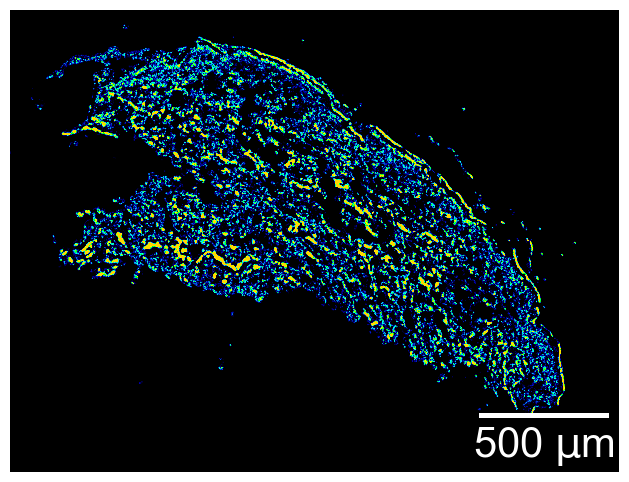

In [34]:
# IMAGES

# Apply Gaussian filter to simulate background subtraction
background = gaussian_filter(deg_ret_15, sigma=5)  # Adjust sigma for more/less blur

# Subtract the background from the original image
corrected_image = deg_ret_15 - background
corrected_image = np.clip(corrected_image, 0, None)

# Adjust corrected_image by subtracting the minimum threshold (0.2) from it
adjusted_image = np.rot90((corrected_image - 0), k=1)

# Plot the corrected image

fig, ax = plt.subplots(figsize=(8, 6))
shw = ax.imshow(adjusted_image, vmin=0, vmax=1, cmap=custom_cmap_11)
ax.axis('off')
# Add a scalebar
pixel_size = 1.625  # micrometers per pixel (update with your actual value)
scalebar = ScaleBar(pixel_size, units="µm", location="lower right",
                    length_fraction=0.25, box_alpha=0, color='white', scale_loc='bottom',
                    font_properties={'family':'Arial','size': 30})

ax.add_artist(scalebar)
# plt.savefig("C:\\Users\\Photon\\Documents\\Eric Min\\EDS study\\images\\Figure 1\\cEDS_ret.eps", format='eps', bbox_inches='tight', pad_inches=0)
plt.show()



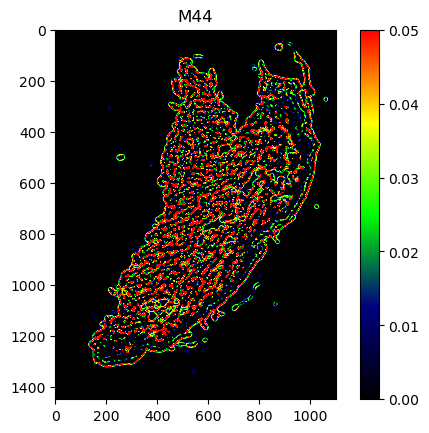

In [35]:
# Apply Gaussian filter to simulate background subtraction
background = gaussian_filter(M_15_33, sigma=5)  # Adjust sigma for more/less blur

# Subtract the background from the original image
corrected_image = M_15_33 - background
corrected_image = np.clip(corrected_image, 0, None)

adjusted_image = corrected_image - 0.01

# Plot the corrected image
fig, ax = plt.subplots()
shw = ax.imshow(adjusted_image, vmin=0, vmax=0.05, cmap=custom_cmap_4)
bar = plt.colorbar(shw)
t = ax.set_title('M44')
plt.show()


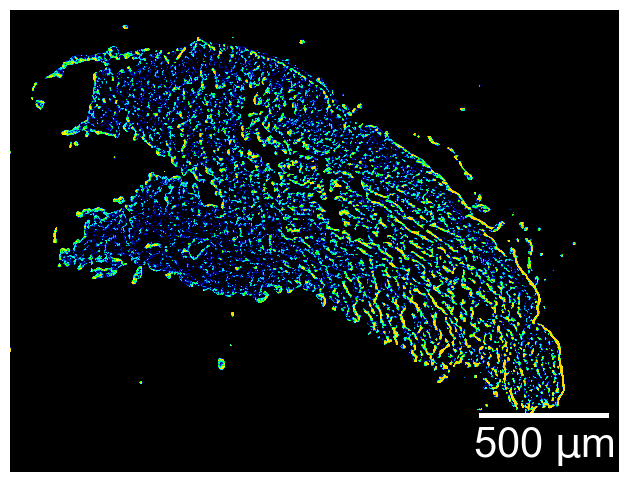

In [36]:
# Diattenuation

# Apply Gaussian filter to simulate background subtraction
background = gaussian_filter(diattenuation_15, sigma=10)  # Adjust sigma for more/less blur

# Subtract the background from the original image
corrected_image = diattenuation_15 - background
corrected_image = np.clip(corrected_image, 0, None)

# Adjust corrected_image by subtracting the minimum threshold (0.2) from it
adjusted_image = np.rot90((corrected_image - 0.0015), k=1)

# Plot the corrected image
fig, ax = plt.subplots(figsize=(8,6))
shw = ax.imshow(adjusted_image, vmin=0, vmax=0.01, cmap=custom_cmap_11)
# Optional: remove axes
ax.axis('off')
# Add a scalebar
pixel_size = 1.625  # micrometers per pixel (update with your actual value)
scalebar = ScaleBar(pixel_size, units="µm", location="lower right",
                    length_fraction=0.25, box_alpha=0, color='white', scale_loc='bottom',
                    font_properties={'family':'Arial','size': 30})

ax.add_artist(scalebar)
# plt.savefig("C:\\Users\\Photon\\Documents\\Eric Min\\EDS study\\images\\Figure 1\\cEDS_diat.eps", format='eps', bbox_inches='tight', pad_inches=0)
plt.show()



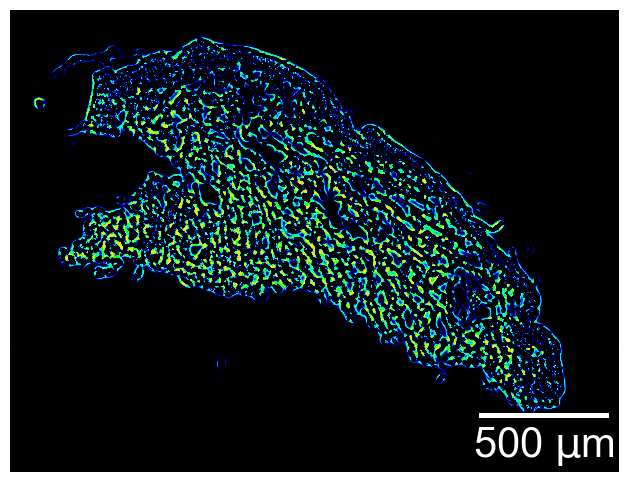

In [37]:
# Depolarization

# Apply Gaussian filter to simulate background subtraction
background = gaussian_filter(Depol_15, sigma=5, mode='wrap')  # Adjust sigma for more/less blur

# Subtract the background from the original image
corrected_image = Depol_15 - background
corrected_image = np.clip(corrected_image, 0, None)

adjusted_image = np.rot90((corrected_image - 0.002), k=1)

# Plot the corrected image
fig, ax = plt.subplots(figsize=(8,6))
shw = ax.imshow(adjusted_image, vmin=0, vmax=0.01, cmap= custom_cmap_11)
# Optional: remove axes
ax.axis('off')
# Add a scalebar
pixel_size = 1.625  # micrometers per pixel (update with your actual value)
scalebar = ScaleBar(pixel_size, units="µm", location="lower right",
                    length_fraction=0.25, box_alpha=0, color='white', scale_loc='bottom',
                    font_properties={'family':'Arial','size': 30})

ax.add_artist(scalebar)
# plt.savefig("C:\\Users\\Photon\\Documents\\Eric Min\\EDS study\\images\\Figure 1\\cEDS_depol.eps", format='eps', bbox_inches='tight', pad_inches=0)
plt.show()


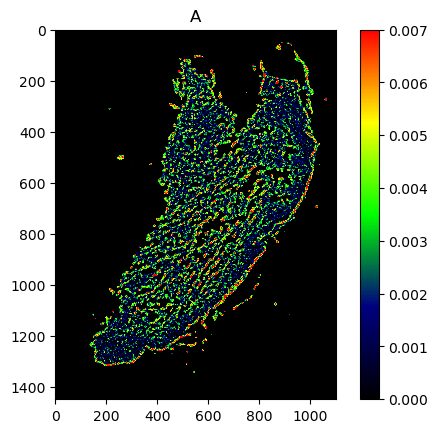

In [38]:
# A

# Apply Gaussian filter to simulate background subtraction
background = gaussian_filter(A_15, sigma=8, mode='wrap')  # Adjust sigma for more/less blur

# Subtract the background from the original image
corrected_image = A_15 - background
corrected_image = np.clip(corrected_image, 0, None)

adjusted_image = corrected_image - 0.002

# Plot the corrected image
fig, ax = plt.subplots()
shw = ax.imshow(adjusted_image, vmin=0, vmax=0.007, cmap= custom_cmap_4)
bar = plt.colorbar(shw)
#bar.set_label('degree')
t = ax.set_title('A')
plt.show()

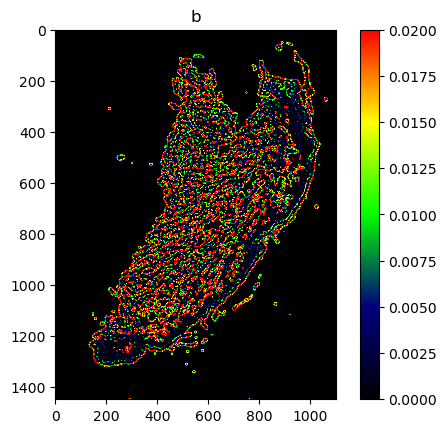

In [39]:
# b

# Apply Gaussian filter to simulate background subtraction
background = gaussian_filter(b_15, sigma=2, mode='wrap')  # Adjust sigma for more/less blur

# Subtract the background from the original image
corrected_image = b_15 - background
corrected_image = np.clip(corrected_image, 0, None)

adjusted_image = corrected_image - 0.003

# Plot the corrected image
fig, ax = plt.subplots()
shw = ax.imshow(adjusted_image, vmin=0, vmax=0.02, cmap= custom_cmap_4)
bar = plt.colorbar(shw)
#bar.set_label('degree')
t = ax.set_title('b')
plt.show()

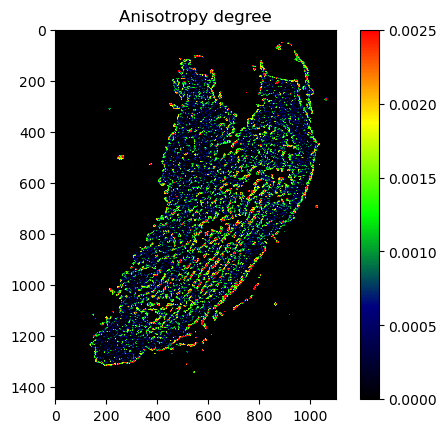

In [40]:
# anisotropy_degree

# Apply Gaussian filter to simulate background subtraction
background = gaussian_filter(anisotropy_degree_15, sigma=8, mode='wrap')  # Adjust sigma for more/less blur

# Subtract the background from the original image
corrected_image = anisotropy_degree_15 - background
corrected_image = np.clip(corrected_image, 0, None)

adjusted_image = corrected_image - 0.001

# Plot the corrected image
fig, ax = plt.subplots()
shw = ax.imshow(adjusted_image, vmin=0, vmax=0.0025, cmap= custom_cmap_4)
bar = plt.colorbar(shw)
#bar.set_label('degree')
t = ax.set_title('Anisotropy degree')
plt.show()

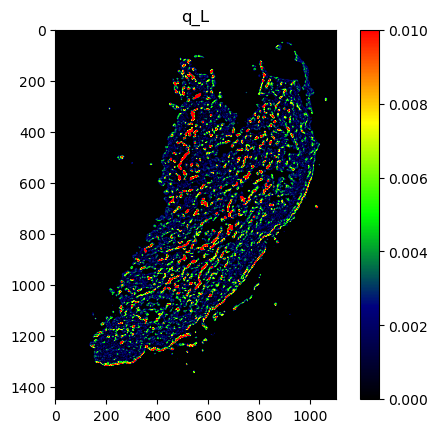

In [41]:
# q_L

# Apply Gaussian filter to simulate background subtraction
background = gaussian_filter(q_L_15, sigma=8, mode='wrap')  # Adjust sigma for more/less blur

# Subtract the background from the original image
corrected_image = q_L_15 - background
corrected_image = np.clip(corrected_image, 0, None)

adjusted_image = corrected_image - 0

# Plot the corrected image
fig, ax = plt.subplots()
shw = ax.imshow(adjusted_image, vmin=0, vmax=0.01, cmap= custom_cmap_4)
bar = plt.colorbar(shw)
#bar.set_label('degree')
t = ax.set_title('q_L')
plt.show()

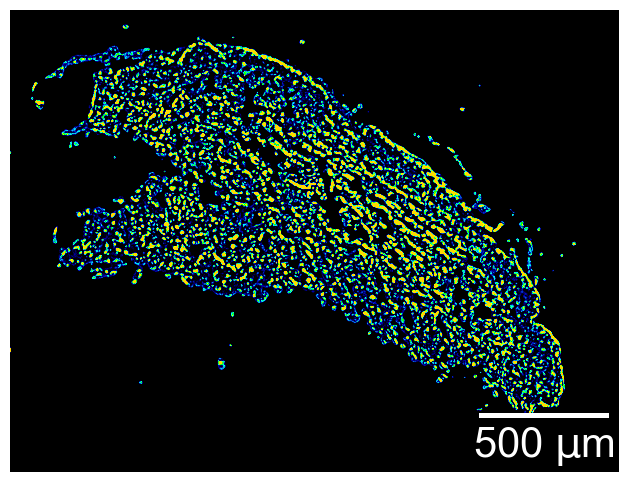

In [42]:
# circular_to_linear

# Apply Gaussian filter to simulate background subtraction
background = gaussian_filter(circular_to_linear_15, sigma=5, mode='wrap')  # Adjust sigma for more/less blur

# Subtract the background from the original image
corrected_image = circular_to_linear_15 - background
corrected_image = np.clip(corrected_image, 0, None)

# Adjust corrected_image by subtracting the minimum threshold (0.2) from it
adjusted_image = np.rot90((corrected_image), k=1)

# Plot the corrected image
fig, ax = plt.subplots(figsize=(8,6))
shw = ax.imshow(adjusted_image, vmin=0, vmax=0.03, cmap=custom_cmap_11)
# Add a scalebar
pixel_size = 1.625  # micrometers per pixel (update with your actual value)
scalebar = ScaleBar(pixel_size, units="µm", location="lower right",
                    length_fraction=0.25, box_alpha=0, color='white', scale_loc='bottom',
                    font_properties={'family':'Arial','size': 30})

ax.add_artist(scalebar)
# Optional: remove axes
ax.axis('off')
# plt.savefig("C:\\Users\\Photon\\Documents\\Eric Min\\EDS study\\images\\Figure 3\\cEDS_rL.eps", format='eps', bbox_inches='tight', pad_inches=0)
plt.show()

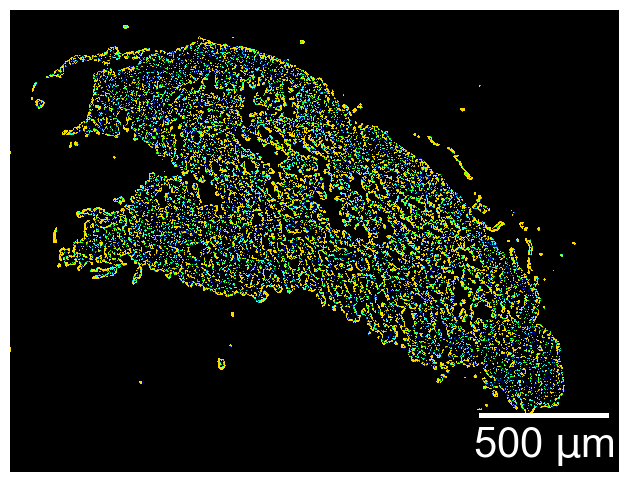

In [43]:
# Linear_polar

# Apply Gaussian filter to simulate background subtraction
background = gaussian_filter(Linear_polar_15, sigma=5, mode='wrap')  # Adjust sigma for more/less blur

# Subtract the background from the original image
corrected_image = Linear_polar_15 - background
corrected_image = np.clip(corrected_image, 0, None)

# Adjust corrected_image by subtracting the minimum threshold (0.2) from it
adjusted_image = np.rot90((corrected_image - 0.0012), k=1)

# Plot the corrected image
fig, ax = plt.subplots(figsize=(8,6))
shw = ax.imshow(adjusted_image, vmin=0, vmax=0.001, cmap=custom_cmap_11)
# Optional: remove axes
ax.axis('off')
# Add a scalebar
pixel_size = 1.625  # micrometers per pixel (update with your actual value)
scalebar = ScaleBar(pixel_size, units="µm", location="lower right",
                    length_fraction=0.25, box_alpha=0, color='white', scale_loc='bottom',
                    font_properties={'family':'Arial','size': 30})

ax.add_artist(scalebar)
# plt.savefig("C:\\Users\\Photon\\Documents\\Eric Min\\EDS study\\images\\Figure 2\\cEDS_pL.eps", format='eps', bbox_inches='tight', pad_inches=0)
plt.show()



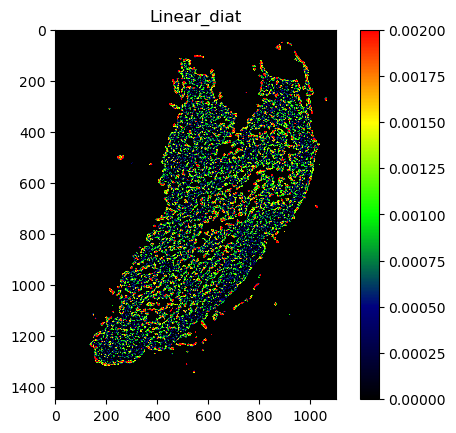

In [44]:
# Linear_diat

# Apply Gaussian filter to simulate background subtraction
background = gaussian_filter(Linear_diat_15, sigma=7, mode='wrap')  # Adjust sigma for more/less blur

# Subtract the background from the original image
corrected_image = Linear_diat_15 - background
corrected_image = np.clip(corrected_image, 0, None)

adjusted_image = corrected_image - 0.001

# Plot the corrected image
fig, ax = plt.subplots()
shw = ax.imshow(adjusted_image, vmin=0, vmax=0.002, cmap= custom_cmap_4)
bar = plt.colorbar(shw)
#bar.set_label('degree')
t = ax.set_title('Linear_diat')
plt.show()


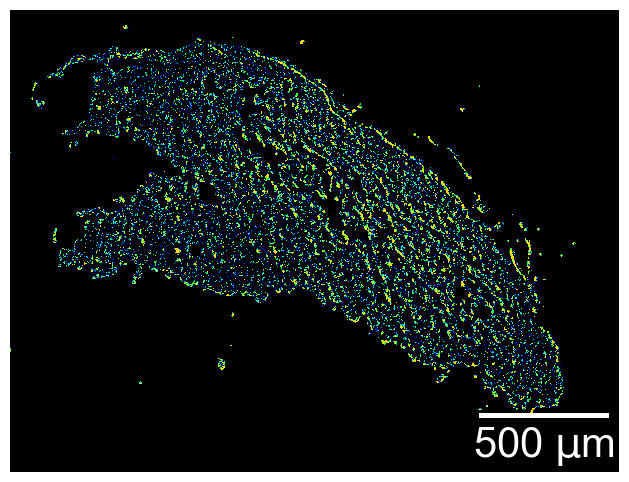

In [45]:
# beta

# Apply Gaussian filter to simulate background subtraction
background = gaussian_filter(beta_15, sigma=8, mode='wrap')  # Adjust sigma for more/less blur

# Subtract the background from the original image
corrected_image = beta_15 - background
corrected_image = np.clip(corrected_image, 0, None)

# Adjust corrected_image by subtracting the minimum threshold (0.2) from it
adjusted_image = np.rot90((corrected_image - 0.0015), k=1)

# Plot the corrected image
fig, ax = plt.subplots(figsize=(8,6))
shw = ax.imshow(adjusted_image, vmin=0, vmax=0.002, cmap=custom_cmap_11)
# Optional: remove axes
ax.axis('off')
# Add a scalebar
pixel_size = 1.625  # micrometers per pixel (update with your actual value)
scalebar = ScaleBar(pixel_size, units="µm", location="lower right",
                    length_fraction=0.25, box_alpha=0, color='white', scale_loc='bottom',
                    font_properties={'family':'Arial','size': 30})

ax.add_artist(scalebar)
# plt.savefig("C:\\Users\\Photon\\Documents\\Eric Min\\EDS study\\images\\Figure 2\\cEDS_beta.eps", format='eps', bbox_inches='tight', pad_inches=0)
plt.show()

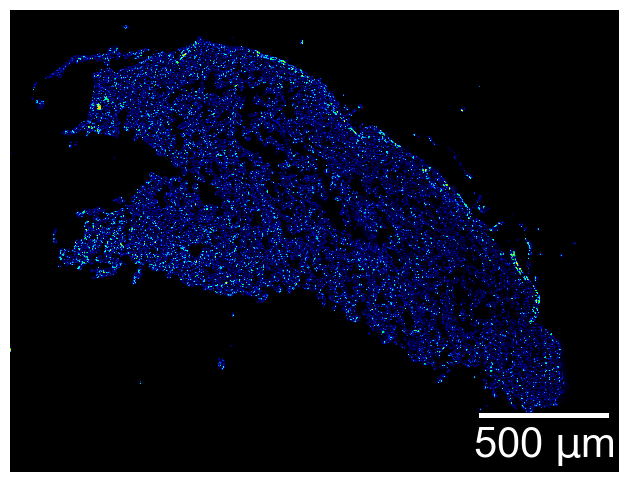

In [46]:
# opt_rot

# Apply Gaussian filter to simulate background subtraction
background = gaussian_filter(opt_rot_15, sigma=9, mode='wrap')  # Adjust sigma for more/less blur

# Subtract the background from the original image
corrected_image = opt_rot_15 - background
corrected_image = np.clip(corrected_image, 0, None)

adjusted_image = np.rot90((corrected_image), k=1)

# Plot the corrected image
fig, ax = plt.subplots(figsize=(8,6))
shw = ax.imshow(adjusted_image, vmin=0, vmax=0.0001, cmap= custom_cmap_11)
ax.axis('off')
# Add a scalebar
pixel_size = 1.625  # micrometers per pixel (update with your actual value)
scalebar = ScaleBar(pixel_size, units="µm", location="lower right",
                    length_fraction=0.25, box_alpha=0, color='white', scale_loc='bottom',
                    font_properties={'family':'Arial','size': 30})

ax.add_artist(scalebar)
# plt.savefig("C:\\Users\\Photon\\Documents\\Eric Min\\EDS study\\images\\Figure 2\\cEDS_opt_rot.eps", format='eps', bbox_inches='tight', pad_inches=0)
plt.show()

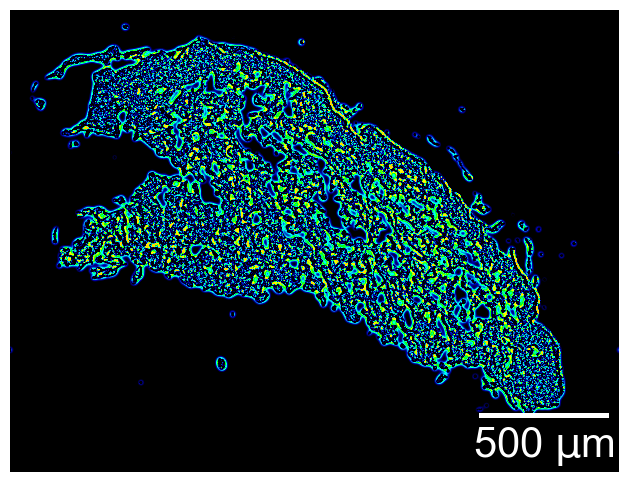

In [47]:
# p_1

# Apply Gaussian filter to simulate background subtraction
background = gaussian_filter(p_1_15, sigma=5, mode='wrap')  # Adjust sigma for more/less blur

# Subtract the background from the original image
corrected_image = p_1_15 - background
corrected_image = np.clip(corrected_image, 0, None)

# Adjust corrected_image by subtracting the minimum threshold (0.2) from it
adjusted_image = np.rot90((corrected_image - 0.0005), k=1)

# Plot the corrected image
fig, ax = plt.subplots(figsize=(8,6))
shw = ax.imshow(adjusted_image, vmin=0, vmax=0.005, cmap=custom_cmap_11)
# Optional: remove axes
ax.axis('off')
# Add a scalebar
pixel_size = 1.625  # micrometers per pixel (update with your actual value)
scalebar = ScaleBar(pixel_size, units="µm", location="lower right",
                    length_fraction=0.25, box_alpha=0, color='white', scale_loc='bottom',
                    font_properties={'family':'Arial','size': 30})

ax.add_artist(scalebar)
# plt.savefig("C:\\Users\\Photon\\Documents\\Eric Min\\EDS study\\images\\Figure 3\\cEDS_p1.eps", format='eps', bbox_inches='tight', pad_inches=0)
plt.show()

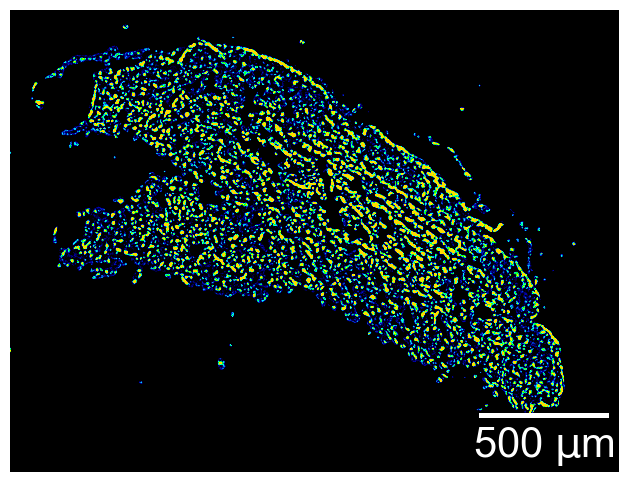

In [48]:
# p_3

# Apply Gaussian filter to simulate background subtraction
background = gaussian_filter(p_3_15, sigma=5, mode='wrap')  # Adjust sigma for more/less blur

# Subtract the background from the original image
corrected_image = p_3_15 - background
corrected_image = np.clip(corrected_image, 0, None)

# Adjust corrected_image by subtracting the minimum threshold (0.2) from it
adjusted_image = np.rot90((corrected_image - 0.0005), k=1)

# Plot the corrected image
fig, ax = plt.subplots(figsize=(8,6))
shw = ax.imshow(adjusted_image, vmin=0, vmax=0.03, cmap=custom_cmap_11)
# Add a scalebar
pixel_size = 1.625  # micrometers per pixel (update with your actual value)
scalebar = ScaleBar(pixel_size, units="µm", location="lower right",
                    length_fraction=0.25, box_alpha=0, color='white', scale_loc='bottom',
                    font_properties={'family':'Arial','size': 30})

ax.add_artist(scalebar)
# Optional: remove axes
ax.axis('off')
# plt.savefig("C:\\Users\\Photon\\Documents\\Eric Min\\EDS study\\images\\Figure 3\\cEDS_p3.eps", format='eps', bbox_inches='tight', pad_inches=0)
plt.show()

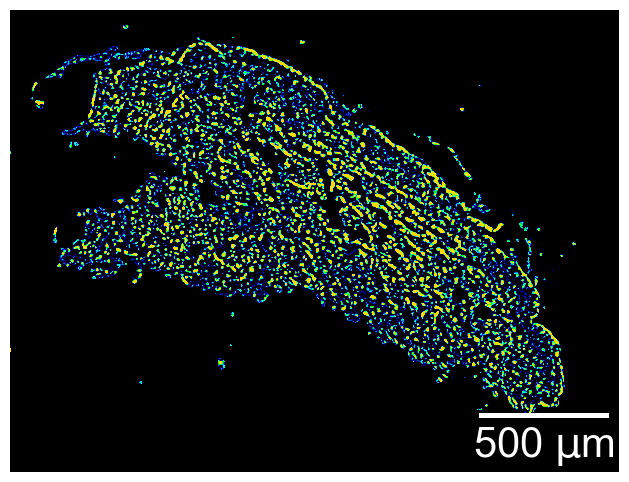

In [49]:
# p_tms

# Apply Gaussian filter to simulate background subtraction
background = gaussian_filter(p_tms_15, sigma=5, mode='wrap')  # Adjust sigma for more/less blur

# Subtract the background from the original image
corrected_image = p_tms_15 - background
corrected_image = np.clip(corrected_image, 0, None)

# Adjust corrected_image by subtracting the minimum threshold (0.2) from it
adjusted_image = np.rot90((corrected_image - 0.0008), k=1)

# Plot the corrected image
fig, ax = plt.subplots(figsize=(8,6))
shw = ax.imshow(adjusted_image, vmin=0, vmax=0.015, cmap=custom_cmap_11)
# Add a scalebar
pixel_size = 1.625  # micrometers per pixel (update with your actual value)
scalebar = ScaleBar(pixel_size, units="µm", location="lower right",
                    length_fraction=0.25, box_alpha=0, color='white', scale_loc='bottom',
                    font_properties={'family':'Arial','size': 30})

ax.add_artist(scalebar)
# Optional: remove axes
ax.axis('off')
# plt.savefig("C:\\Users\\Photon\\Documents\\Eric Min\\EDS study\\images\\Figure 3\\cEDS_ptms.eps", format='eps', bbox_inches='tight', pad_inches=0)
plt.show()


In [50]:
# HISTOGRAMS for reference#

In [51]:
# M parameters 

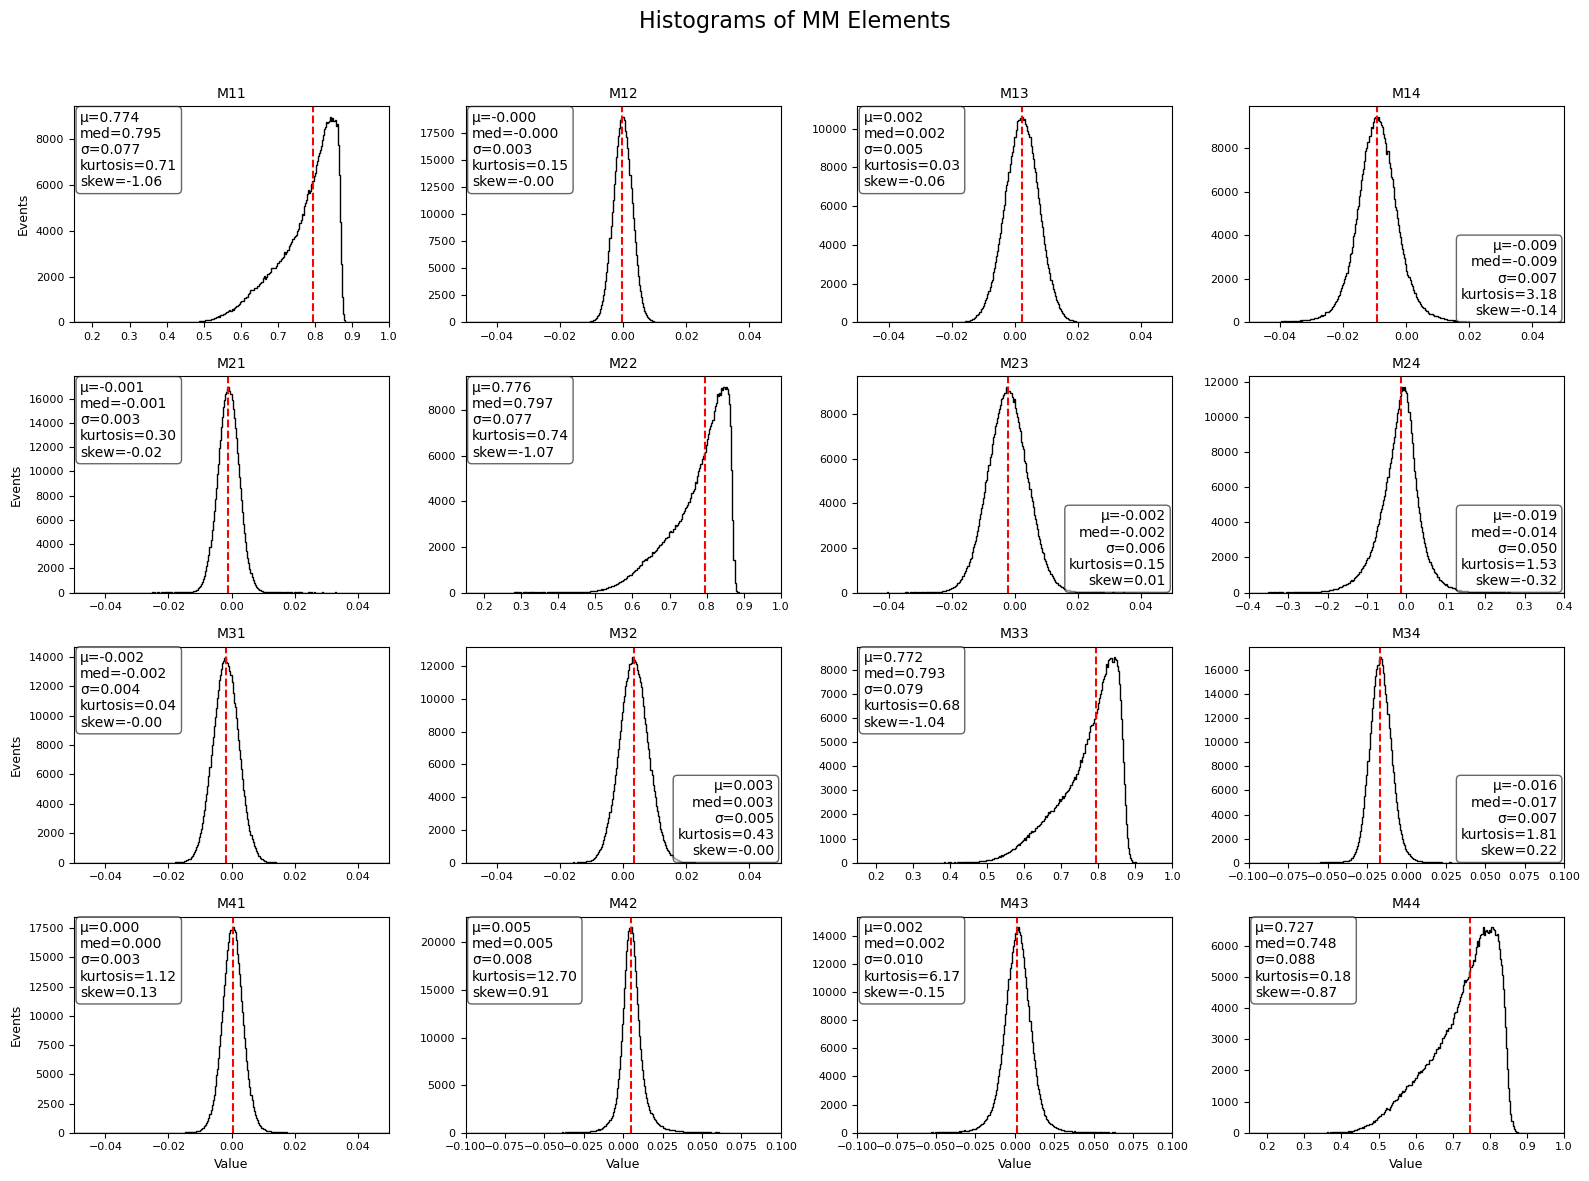

In [52]:
MM_elements = {
    'M11': M_15_00,
    'M12': M_15_01,
    'M13': M_15_02,
    'M14': M_15_03,
    'M21': M_15_10,
    'M22': M_15_11,
    'M23': M_15_12,
    'M24': M_15_13,
    'M31': M_15_20,
    'M32': M_15_21,
    'M33': M_15_22,
    'M34': M_15_23,
    'M41': M_15_30,
    'M42': M_15_31,
    'M43': M_15_32,
    'M44': M_15_33,
}

# Default configuration
default_bins = 300
default_range = (-0.05, 0.05)

# Customisable configuration
custom_config = {
    'M42': {'bins': 300, 'range': (-0.1, 0.1)},
    'M43': {'bins': 300, 'range': (-0.1, 0.1)},
    'M34': {'bins': 300, 'range': (-0.1, 0.1)},
    'M24': {'bins': 300, 'range': (-0.4, 0.4)},
    'M11': {'bins': 300, 'range': (0.15, 1)},
    'M22': {'bins': 300, 'range': (0.15, 1)},
    'M33': {'bins': 300, 'range': (0.15, 1)},
    'M44': {'bins': 300, 'range': (0.15, 1)}
    # Add other specific configs if needed
}

# Create 4x4 subplots
fig, axes = plt.subplots(4, 4, figsize=(16, 12))
fig.suptitle("Histograms of MM Elements", fontsize=16)

for idx, (name, matrix) in enumerate(MM_elements.items()):
    ax = axes[idx // 4, idx % 4]

    # Apply tissue mask to extract only relevant pixels
    tissue_values = matrix[tissue_mask]

    config = custom_config.get(name, {'bins': default_bins, 'range': default_range})

    # Plot histogram only for tissue pixels
    counts, bin_edges, _ = ax.hist(tissue_values, bins=config['bins'], range=config['range'],
                                    color='black', histtype='step')

    # Compute stats
    mean_val, median_val, std_val, kurt_val, skew_val = parameter_stats(matrix, tissue_mask)
    
    # Format and display stats
    stats_text = (
        f"μ={mean_val:.3f}\n"
        f"med={median_val:.3f}\n"
        f"σ={std_val:.3f}\n"
        f"kurtosis={kurt_val:.2f}\n"
        f"skew={skew_val:.2f}"
    )
    # Find quadrant with least activity
    half = len(counts) // 2
    q1 = np.mean(counts[:half // 2])      # top-left
    q2 = np.mean(counts[half // 2:half])  # top-right
    q3 = np.mean(counts[half:half + half // 2])  # bottom-left
    q4 = np.mean(counts[half + half // 2:])      # bottom-right
    
    quadrant_scores = {
        'top-left': q1,
        'top-right': q2,
        'bottom-left': q3,
        'bottom-right': q4
    }
    best_quadrant = min(quadrant_scores, key=quadrant_scores.get)
    
    # Map best quadrant to axes-relative position
    positions = {
        'top-left': (0.02, 0.98, 'left', 'top'),
        'top-right': (0.98, 0.98, 'right', 'top'),
        'bottom-left': (0.02, 0.02, 'left', 'bottom'),
        'bottom-right': (0.98, 0.02, 'right', 'bottom'),
    }
    x, y, ha, va = positions[best_quadrant]
    
    # Place text at chosen quadrant
    ax.text(
        x, y, stats_text,
        transform=ax.transAxes,
        fontsize=10, va=va, ha=ha,
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.6)
    )
    ax.axvline(median_val, color = 'red', linestyle = '--')

    ax.set_title(name, fontsize=10)
    ax.set_xlim(config['range'])
    ax.tick_params(labelsize=8)

    if idx % 4 == 0:
        ax.set_ylabel('Events', fontsize=9)
    if idx // 4 == 3:
        ax.set_xlabel('Value', fontsize=9)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()



In [53]:
# p parameters

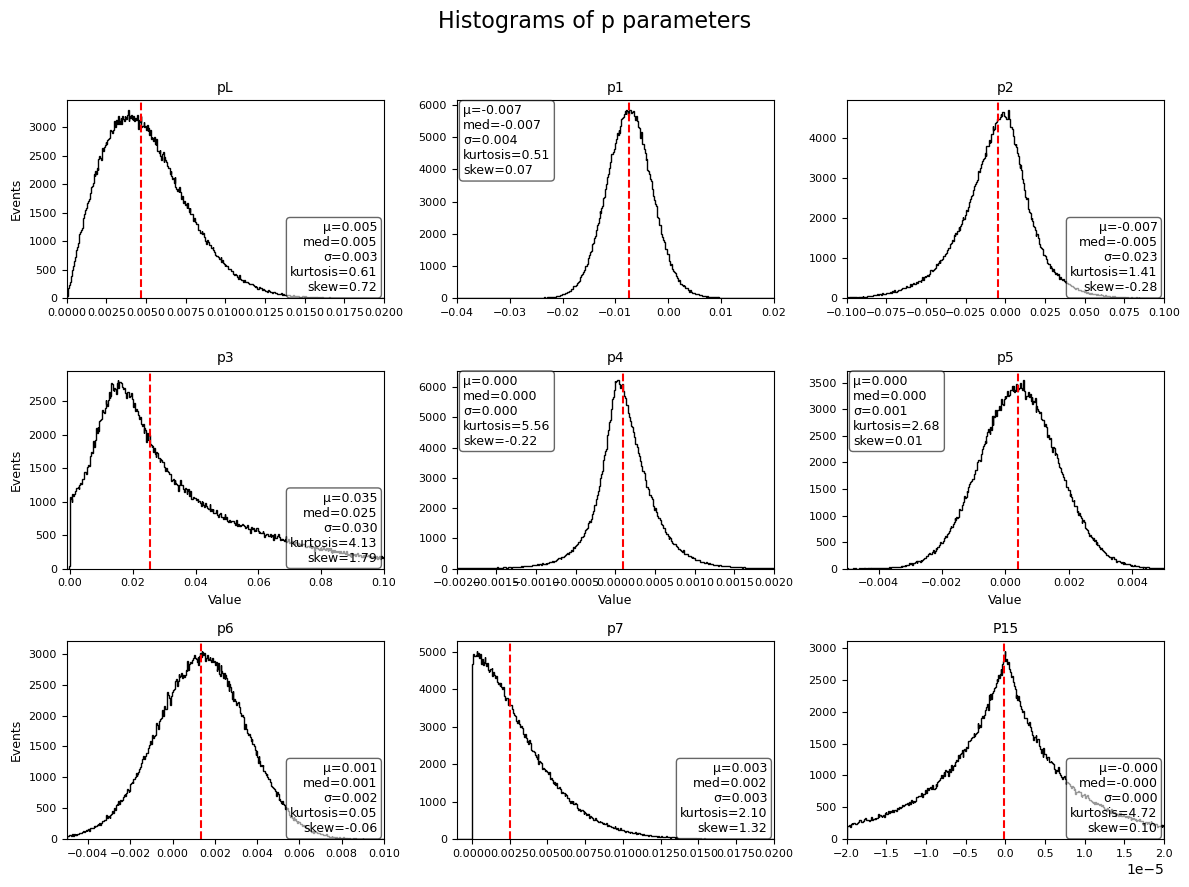

In [54]:
p_elements = {
    'pL': p_L_15,
    'p1': p_1_15,
    'p2': p_2_15,
    'p3': p_3_15,
    'p4': p_4_15,
    'p5': p_5_15,
    'p6': p_6_15,
    'p7': p_7_15,
    'P15': p_8_15
}

# Default configuration
default_bins = 400
default_range = (-0.005, 0.005)

# Customisable configuration
custom_config = {
    'pL': {'bins': 400, 'range': (0, 0.02)},
    'p1': {'bins': 400, 'range': (-0.04, 0.02)},
    'p2': {'bins': 400, 'range': (-0.1, 0.1)},
    'p3': {'bins': 400, 'range': (-0.001, 0.1)},
    'p4': {'bins': 400, 'range': (-0.002, 0.002)},
    'p7': {'bins': 400, 'range': (-0.001, 0.02)},
    'p6': {'bins': 400, 'range': (-0.005, 0.01)},
    'P15': {'bins': 400, 'range': (-2E-05, 2E-05)}
    # Add other specific configs if needed
}
# Create 3x3 subplots
fig, axes = plt.subplots(3, 3, figsize=(12, 9))
fig.suptitle("Histograms of p parameters", fontsize=16)

for idx, (name, matrix) in enumerate(p_elements.items()):
    ax = axes[idx // 3, idx % 3]

    # Apply tissue mask to extract only relevant pixels
    tissue_values = matrix[tissue_mask]

    config = custom_config.get(name, {'bins': default_bins, 'range': default_range})

    # Plot histogram only for tissue pixels
    counts, bin_edges, _ = ax.hist(tissue_values, bins=config['bins'], range=config['range'],
                                    color='black', histtype='step')

    # Compute stats
    mean_val, median_val, std_val, kurt_val, skew_val = parameter_stats(matrix, tissue_mask)
    
    # Format and display stats
    stats_text = (
        f"μ={mean_val:.3f}\n"
        f"med={median_val:.3f}\n"
        f"σ={std_val:.3f}\n"
        f"kurtosis={kurt_val:.2f}\n"
        f"skew={skew_val:.2f}"
    )
    # Find quadrant with least activity
    half = len(counts) // 2
    q1 = np.mean(counts[:half // 2])      # top-left
    q2 = np.mean(counts[half // 2:half])  # top-right
    q3 = np.mean(counts[half:half + half // 2])  # bottom-left
    q4 = np.mean(counts[half + half // 2:])      # bottom-right
    
    quadrant_scores = {
        'top-left': q1,
        'top-right': q2,
        'bottom-left': q3,
        'bottom-right': q4
    }
    best_quadrant = min(quadrant_scores, key=quadrant_scores.get)
    
    # Map best quadrant to axes-relative position
    positions = {
        'top-left': (0.02, 0.98, 'left', 'top'),
        'top-right': (0.98, 0.98, 'right', 'top'),
        'bottom-left': (0.02, 0.02, 'left', 'bottom'),
        'bottom-right': (0.98, 0.02, 'right', 'bottom'),
    }
    x, y, ha, va = positions[best_quadrant]
    
    # Place text at chosen quadrant
    ax.text(
        x, y, stats_text,
        transform=ax.transAxes,
        fontsize=9, va=va, ha=ha,
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.6)
    )
    ax.axvline(median_val, color = 'red', linestyle = '--')

    ax.set_title(name, fontsize=10)
    ax.set_xlim(config['range'])
    ax.tick_params(labelsize=8)

    if idx % 3 == 0:
        ax.set_ylabel('Events', fontsize=9)
    if idx // 3 == 1:
        ax.set_xlabel('Value', fontsize=9)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


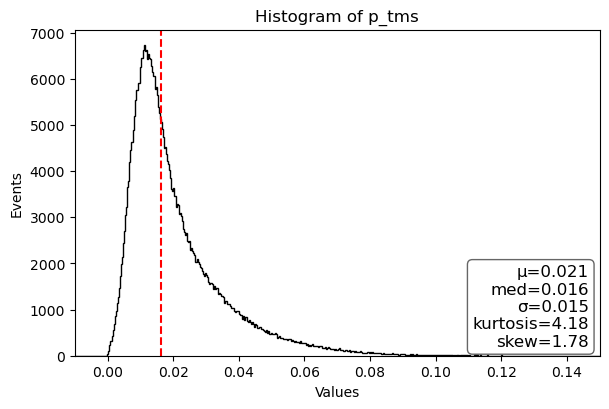

In [55]:
# p_tms
num_bins = 500
bin_range = (-0.01, 0.15)

# Prepare data
tissue_values = p_tms_15[tissue_mask]

# Set up figure and axis properly
fig, ax = plt.subplots(figsize=(6, 4))

# Plot histogram on that axis
counts, bin_edges, _ = ax.hist(
    tissue_values, bins=num_bins, range=bin_range,
    color='black', histtype='step'
)

# Compute stats (assuming you've done this already)
stats_text = (
    f"μ={avg_p_tms_15:.3f}\n"
    f"med={med_p_tms_15:.3f}\n"
    f"σ={std_p_tms_15:.3f}\n"
    f"kurtosis={kurt_p_tms_15:.2f}\n"
    f"skew={skew_p_tms_15:.2f}"
)

# Find quadrant with least activity
half = len(counts) // 2
q1 = np.mean(counts[:half // 2])      # top-left
q2 = np.mean(counts[half // 2:half])  # top-right
q3 = np.mean(counts[half:half + half // 2])  # bottom-left
q4 = np.mean(counts[half + half // 2:])      # bottom-right

quadrant_scores = {
    'top-left': q1,
    'top-right': q2,
    'bottom-left': q3,
    'bottom-right': q4
}
best_quadrant = min(quadrant_scores, key=quadrant_scores.get)

# Map best quadrant to axes-relative position
positions = {
    'top-left': (0.02, 0.98, 'left', 'top'),
    'top-right': (0.98, 0.98, 'right', 'top'),
    'bottom-left': (0.02, 0.02, 'left', 'bottom'),
    'bottom-right': (0.98, 0.02, 'right', 'bottom'),
}
x, y, ha, va = positions[best_quadrant]

# Place text dynamically within the plot (axes-relative coords)
ax.text(
    x, y, stats_text,
    transform=ax.transAxes,
    fontsize=12, va=va, ha=ha,
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.6)
)

# Add vertical line at median
ax.axvline(med_p_tms_15, color='red', linestyle='--')

# Title and limits
ax.set_title('Histogram of p_tms')
ax.set_xlim(bin_range)

plt.tight_layout()
plt.xlabel('Values')
plt.ylabel('Events')
plt.show()


In [56]:
# Retardance #

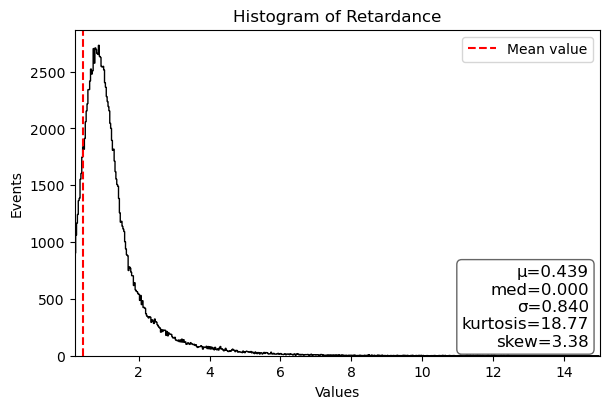

In [57]:
num_bins = 600
bin_range = (0.2,15)

# Prepare data
tissue_values = deg_ret_15[tissue_mask]

# Set up figure and axis properly
fig, ax = plt.subplots(figsize=(6, 4))

# Plot histogram on that axis
counts, bin_edges, _ = ax.hist(
    tissue_values, bins=num_bins, range=bin_range,
    color='black', histtype='step'
)

# Compute stats (assuming you've done this already)
stats_text = (
    f"μ={avg_deg_ret_15:.3f}\n"
    f"med={med_deg_ret_15:.3f}\n"
    f"σ={std_deg_ret_15:.3f}\n"
    f"kurtosis={kurt_deg_ret_15:.2f}\n"
    f"skew={skew_deg_ret_15:.2f}"
)

# Find quadrant with least activity
half = len(counts) // 2
q1 = np.mean(counts[:half // 2])      # top-left
q2 = np.mean(counts[half // 2:half])  # top-right
q3 = np.mean(counts[half:half + half // 2])  # bottom-left
q4 = np.mean(counts[half + half // 2:])      # bottom-right

quadrant_scores = {
    'top-left': q1,
    'top-right': q2,
    'bottom-left': q3,
    'bottom-right': q4
}
best_quadrant = min(quadrant_scores, key=quadrant_scores.get)

# Map best quadrant to axes-relative position
positions = {
    'top-left': (0.02, 0.98, 'left', 'top'),
    'top-right': (0.98, 0.98, 'right', 'top'),
    'bottom-left': (0.02, 0.02, 'left', 'bottom'),
    'bottom-right': (0.98, 0.02, 'right', 'bottom'),
}
x, y, ha, va = positions[best_quadrant]

# Place text dynamically within the plot (axes-relative coords)
ax.text(
    x, y, stats_text,
    transform=ax.transAxes,
    fontsize=12, va=va, ha=ha,
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.6)
)

# Add vertical line at median
ax.axvline(avg_deg_ret_15, color='red', linestyle='--', label = 'Mean value')

# Title and limits
ax.set_title('Histogram of Retardance')
ax.set_xlim(bin_range)

plt.tight_layout()
plt.legend(loc = 'upper right')
plt.xlabel('Values')
plt.ylabel('Events')
plt.show()

In [58]:
print(tissue_values)

[0.         0.         0.         ... 0.         1.22379485 1.9923533 ]


In [59]:
print(deg_ret_15)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [60]:
# Diattenuation #

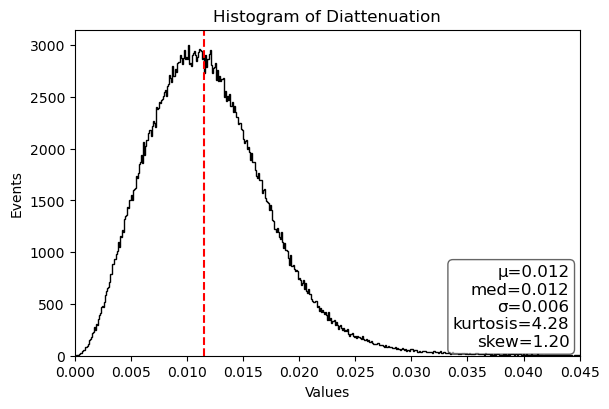

In [61]:
num_bins = 500
bin_range = (0, 0.045)

# Prepare data
tissue_values = diattenuation_15[tissue_mask]

# Set up figure and axis properly
fig, ax = plt.subplots(figsize=(6, 4))

# Plot histogram on that axis
counts, bin_edges, _ = ax.hist(
    tissue_values, bins=num_bins, range=bin_range,
    color='black', histtype='step'
)

# Compute stats (assuming you've done this already)
stats_text = (
    f"μ={avg_diattenuation_15:.3f}\n"
    f"med={med_diattenuation_15:.3f}\n"
    f"σ={std_diattenuation_15:.3f}\n"
    f"kurtosis={kurt_diattenuation_15:.2f}\n"
    f"skew={skew_diattenuation_15:.2f}"
)

# Find quadrant with least activity
half = len(counts) // 2
q1 = np.mean(counts[:half // 2])      # top-left
q2 = np.mean(counts[half // 2:half])  # top-right
q3 = np.mean(counts[half:half + half // 2])  # bottom-left
q4 = np.mean(counts[half + half // 2:])      # bottom-right

quadrant_scores = {
    'top-left': q1,
    'top-right': q2,
    'bottom-left': q3,
    'bottom-right': q4
}
best_quadrant = min(quadrant_scores, key=quadrant_scores.get)

# Map best quadrant to axes-relative position
positions = {
    'top-left': (0.02, 0.98, 'left', 'top'),
    'top-right': (0.98, 0.98, 'right', 'top'),
    'bottom-left': (0.02, 0.02, 'left', 'bottom'),
    'bottom-right': (0.98, 0.02, 'right', 'bottom'),
}
x, y, ha, va = positions[best_quadrant]

# Place text dynamically within the plot (axes-relative coords)
ax.text(
    x, y, stats_text,
    transform=ax.transAxes,
    fontsize=12, va=va, ha=ha,
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.6)
)

# Add vertical line at median
ax.axvline(med_diattenuation_15, color='red', linestyle='--')

# Title and limits
ax.set_title('Histogram of Diattenuation')
ax.set_xlim(bin_range)

plt.tight_layout()
plt.xlabel('Values')
plt.ylabel('Events')
plt.show()


In [62]:
# Depolarization #

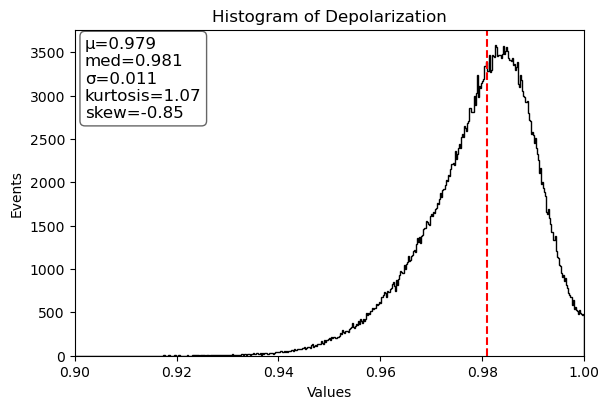

In [63]:
num_bins = 500
bin_range = (0.9,1)


# Prepare data
tissue_values = Depol_15[tissue_mask]

# Set up figure and axis properly
fig, ax = plt.subplots(figsize=(6, 4))

# Plot histogram on that axis
counts, bin_edges, _ = ax.hist(
    tissue_values, bins=num_bins, range=bin_range,
    color='black', histtype='step'
)

# Compute stats (assuming you've done this already)
stats_text = (
    f"μ={avg_Depol_15:.3f}\n"
    f"med={med_Depol_15:.3f}\n"
    f"σ={std_Depol_15:.3f}\n"
    f"kurtosis={kurt_Depol_15:.2f}\n"
    f"skew={skew_Depol_15:.2f}"
)

# Find quadrant with least activity
half = len(counts) // 2
q1 = np.mean(counts[:half // 2])      # top-left
q2 = np.mean(counts[half // 2:half])  # top-right
q3 = np.mean(counts[half:half + half // 2])  # bottom-left
q4 = np.mean(counts[half + half // 2:])      # bottom-right

quadrant_scores = {
    'top-left': q1,
    'top-right': q2,
    'bottom-left': q3,
    'bottom-right': q4
}
best_quadrant = min(quadrant_scores, key=quadrant_scores.get)

# Map best quadrant to axes-relative position
positions = {
    'top-left': (0.02, 0.98, 'left', 'top'),
    'top-right': (0.98, 0.98, 'right', 'top'),
    'bottom-left': (0.02, 0.02, 'left', 'bottom'),
    'bottom-right': (0.98, 0.02, 'right', 'bottom'),
}
x, y, ha, va = positions[best_quadrant]

# Place text dynamically within the plot (axes-relative coords)
ax.text(
    x, y, stats_text,
    transform=ax.transAxes,
    fontsize=12, va=va, ha=ha,
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.6)
)

# Add vertical line at median
ax.axvline(med_Depol_15, color='red', linestyle='--')

# Title and limits
ax.set_title('Histogram of Depolarization')
ax.set_xlim(bin_range)

plt.tight_layout()
plt.xlabel('Values')
plt.ylabel('Events')
plt.show()

In [64]:
# A #

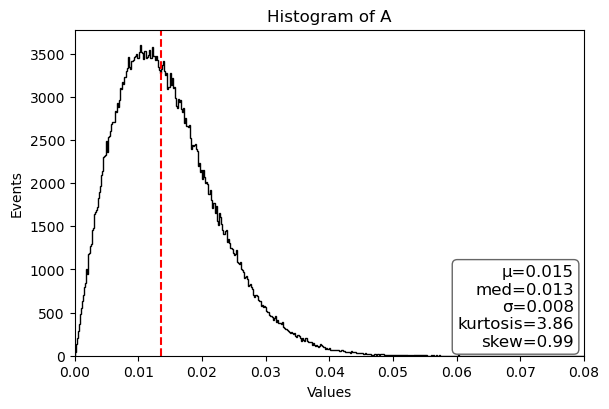

In [65]:
num_bins = 500
bin_range = (0,0.08)

# Prepare data
tissue_values = A_15[tissue_mask]

# Set up figure and axis properly
fig, ax = plt.subplots(figsize=(6, 4))

# Plot histogram on that axis
counts, bin_edges, _ = ax.hist(
    tissue_values, bins=num_bins, range=bin_range,
    color='black', histtype='step'
)

# Compute stats (assuming you've done this already)
stats_text = (
    f"μ={avg_A_15:.3f}\n"
    f"med={med_A_15:.3f}\n"
    f"σ={std_A_15:.3f}\n"
    f"kurtosis={kurt_A_15:.2f}\n"
    f"skew={skew_A_15:.2f}"
)

# Find quadrant with least activity
half = len(counts) // 2
q1 = np.mean(counts[:half // 2])      # top-left
q2 = np.mean(counts[half // 2:half])  # top-right
q3 = np.mean(counts[half:half + half // 2])  # bottom-left
q4 = np.mean(counts[half + half // 2:])      # bottom-right

quadrant_scores = {
    'top-left': q1,
    'top-right': q2,
    'bottom-left': q3,
    'bottom-right': q4
}
best_quadrant = min(quadrant_scores, key=quadrant_scores.get)

# Map best quadrant to axes-relative position
positions = {
    'top-left': (0.02, 0.98, 'left', 'top'),
    'top-right': (0.98, 0.98, 'right', 'top'),
    'bottom-left': (0.02, 0.02, 'left', 'bottom'),
    'bottom-right': (0.98, 0.02, 'right', 'bottom'),
}
x, y, ha, va = positions[best_quadrant]

# Place text dynamically within the plot (axes-relative coords)
ax.text(
    x, y, stats_text,
    transform=ax.transAxes,
    fontsize=12, va=va, ha=ha,
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.6)
)

# Add vertical line at median
ax.axvline(med_A_15, color='red', linestyle='--')

# Title and limits
ax.set_title('Histogram of A')
ax.set_xlim(bin_range)

plt.tight_layout()
plt.xlabel('Values')
plt.ylabel('Events')
plt.show()

In [66]:
# b #

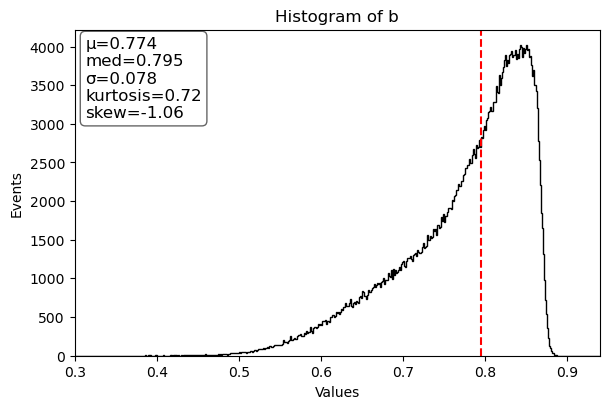

In [67]:
num_bins = 500
bin_range = (0.3,0.94)

# Prepare data
tissue_values = b_15[tissue_mask]

# Set up figure and axis properly
fig, ax = plt.subplots(figsize=(6, 4))

# Plot histogram on that axis
counts, bin_edges, _ = ax.hist(
    tissue_values, bins=num_bins, range=bin_range,
    color='black', histtype='step'
)

# Compute stats (assuming you've done this already)
stats_text = (
    f"μ={avg_b_15:.3f}\n"
    f"med={med_b_15:.3f}\n"
    f"σ={std_b_15:.3f}\n"
    f"kurtosis={kurt_b_15:.2f}\n"
    f"skew={skew_b_15:.2f}"
)

# Find quadrant with least activity
half = len(counts) // 2
q1 = np.mean(counts[:half // 2])      # top-left
q2 = np.mean(counts[half // 2:half])  # top-right
q3 = np.mean(counts[half:half + half // 2])  # bottom-left
q4 = np.mean(counts[half + half // 2:])      # bottom-right

quadrant_scores = {
    'top-left': q1,
    'top-right': q2,
    'bottom-left': q3,
    'bottom-right': q4
}
best_quadrant = min(quadrant_scores, key=quadrant_scores.get)

# Map best quadrant to axes-relative position
positions = {
    'top-left': (0.02, 0.98, 'left', 'top'),
    'top-right': (0.98, 0.98, 'right', 'top'),
    'bottom-left': (0.02, 0.02, 'left', 'bottom'),
    'bottom-right': (0.98, 0.02, 'right', 'bottom'),
}
x, y, ha, va = positions[best_quadrant]

# Place text dynamically within the plot (axes-relative coords)
ax.text(
    x, y, stats_text,
    transform=ax.transAxes,
    fontsize=12, va=va, ha=ha,
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.6)
)

# Add vertical line at median
ax.axvline(med_b_15, color='red', linestyle='--')

# Title and limits
ax.set_title('Histogram of b')
ax.set_xlim(bin_range)

plt.tight_layout()
plt.xlabel('Values')
plt.ylabel('Events')
plt.show()

In [68]:
# anisotropy degree #

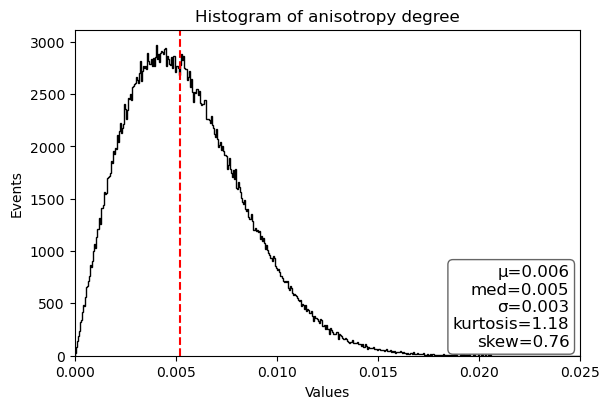

In [69]:
num_bins = 500
bin_range = (0,0.025)

# Prepare data
tissue_values = anisotropy_degree_15[tissue_mask]

# Set up figure and axis properly
fig, ax = plt.subplots(figsize=(6, 4))

# Plot histogram on that axis
counts, bin_edges, _ = ax.hist(
    tissue_values, bins=num_bins, range=bin_range,
    color='black', histtype='step'
)

# Compute stats (assuming you've done this already)
stats_text = (
    f"μ={avg_anisotropy_degree_15:.3f}\n"
    f"med={med_anisotropy_degree_15:.3f}\n"
    f"σ={std_anisotropy_degree_15:.3f}\n"
    f"kurtosis={kurt_anisotropy_degree_15:.2f}\n"
    f"skew={skew_anisotropy_degree_15:.2f}"
)

# Find quadrant with least activity
half = len(counts) // 2
q1 = np.mean(counts[:half // 2])      # top-left
q2 = np.mean(counts[half // 2:half])  # top-right
q3 = np.mean(counts[half:half + half // 2])  # bottom-left
q4 = np.mean(counts[half + half // 2:])      # bottom-right

quadrant_scores = {
    'top-left': q1,
    'top-right': q2,
    'bottom-left': q3,
    'bottom-right': q4
}
best_quadrant = min(quadrant_scores, key=quadrant_scores.get)

# Map best quadrant to axes-relative position
positions = {
    'top-left': (0.02, 0.98, 'left', 'top'),
    'top-right': (0.98, 0.98, 'right', 'top'),
    'bottom-left': (0.02, 0.02, 'left', 'bottom'),
    'bottom-right': (0.98, 0.02, 'right', 'bottom'),
}
x, y, ha, va = positions[best_quadrant]

# Place text dynamically within the plot (axes-relative coords)
ax.text(
    x, y, stats_text,
    transform=ax.transAxes,
    fontsize=12, va=va, ha=ha,
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.6)
)

# Add vertical line at median
ax.axvline(med_anisotropy_degree_15, color='red', linestyle='--')

# Title and limits
ax.set_title('Histogram of anisotropy degree')
ax.set_xlim(bin_range)

plt.tight_layout()
plt.xlabel('Values')
plt.ylabel('Events')
plt.show()

In [70]:
# q_L #

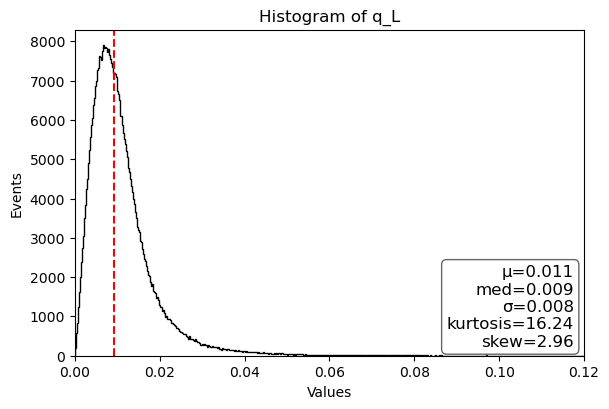

In [71]:
num_bins = 500
bin_range = (0,0.12)

# Prepare data
tissue_values = q_L_15[tissue_mask]

# Set up figure and axis properly
fig, ax = plt.subplots(figsize=(6, 4))

# Plot histogram on that axis
counts, bin_edges, _ = ax.hist(
    tissue_values, bins=num_bins, range=bin_range,
    color='black', histtype='step'
)

# Compute stats (assuming you've done this already)
stats_text = (
    f"μ={avg_q_L_15:.3f}\n"
    f"med={med_q_L_15:.3f}\n"
    f"σ={std_q_L_15:.3f}\n"
    f"kurtosis={kurt_q_L_15:.2f}\n"
    f"skew={skew_q_L_15:.2f}"
)

# Find quadrant with least activity
half = len(counts) // 2
q1 = np.mean(counts[:half // 2])      # top-left
q2 = np.mean(counts[half // 2:half])  # top-right
q3 = np.mean(counts[half:half + half // 2])  # bottom-left
q4 = np.mean(counts[half + half // 2:])      # bottom-right

quadrant_scores = {
    'top-left': q1,
    'top-right': q2,
    'bottom-left': q3,
    'bottom-right': q4
}
best_quadrant = min(quadrant_scores, key=quadrant_scores.get)

# Map best quadrant to axes-relative position
positions = {
    'top-left': (0.02, 0.98, 'left', 'top'),
    'top-right': (0.98, 0.98, 'right', 'top'),
    'bottom-left': (0.02, 0.02, 'left', 'bottom'),
    'bottom-right': (0.98, 0.02, 'right', 'bottom'),
}
x, y, ha, va = positions[best_quadrant]

# Place text dynamically within the plot (axes-relative coords)
ax.text(
    x, y, stats_text,
    transform=ax.transAxes,
    fontsize=12, va=va, ha=ha,
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.6)
)

# Add vertical line at median
ax.axvline(med_q_L_15, color='red', linestyle='--')

# Title and limits
ax.set_title('Histogram of q_L')
ax.set_xlim(bin_range)

plt.tight_layout()
plt.xlabel('Values')
plt.ylabel('Events')
plt.show()

In [72]:
# x #

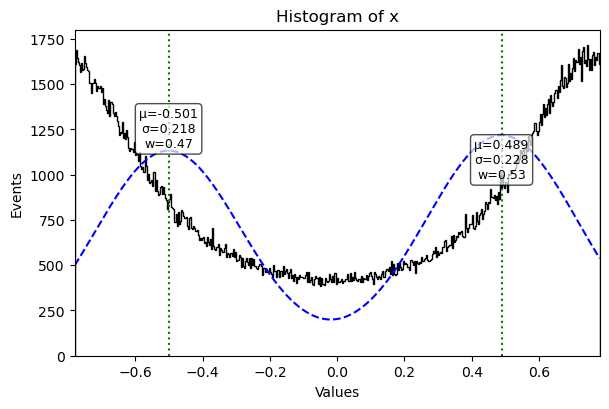

In [73]:
num_bins = 500
bin_range = (-0.78,0.78)

# Prepare data
tissue_values = x_15[tissue_mask]

# Set up figure and axis properly
fig, ax = plt.subplots(figsize=(6, 4))

# Plot histogram on that axis
counts, bin_edges, _ = ax.hist(
    tissue_values, bins=num_bins, range=bin_range,
    color='black', histtype='step'
)

# Fit a 2-component GMM
values_reshaped = tissue_values.reshape(-1, 1)
gmm = GaussianMixture(n_components=2, random_state=0, means_init=np.array([[-0.78], [0.7]]))
gmm.fit(values_reshaped)
means = gmm.means_.flatten()
stds = np.sqrt(gmm.covariances_).flatten()
weights = gmm.weights_

# Plot GMM PDF scaled to histogram
x = np.linspace(*bin_range, 1000).reshape(-1, 1)
gmm_pdf = np.exp(gmm.score_samples(x))
ax.plot(x, gmm_pdf * len(tissue_values) * (bin_range[1] - bin_range[0]) / num_bins,
        color='blue', linestyle='--', label='GMM fit')

# Annotate GMM components
for i in range(2):
    ax.axvline(means[i], color='green', linestyle=':', label=f'Mode {i+1} μ={means[i]:.3f}')
    ax.text(
        means[i], max(counts) * 0.8 - i * max(counts) * 0.1,
        f"μ={means[i]:.3f}\nσ={stds[i]:.3f}\nw={weights[i]:.2f}",
        fontsize=9, ha='center', va='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.7)
    )


# Title and limits
ax.set_title('Histogram of x')
ax.set_xlim(bin_range)

plt.tight_layout()
plt.xlabel('Values')
plt.ylabel('Events')
plt.show()

In [74]:
print(tissue_values)
print(values_reshaped)

[ 0.55756824 -0.47526015  0.12817374 ... -0.77729711  0.55095854
  0.44214571]
[[ 0.55756824]
 [-0.47526015]
 [ 0.12817374]
 ...
 [-0.77729711]
 [ 0.55095854]
 [ 0.44214571]]


In [75]:
# Circular to linear #

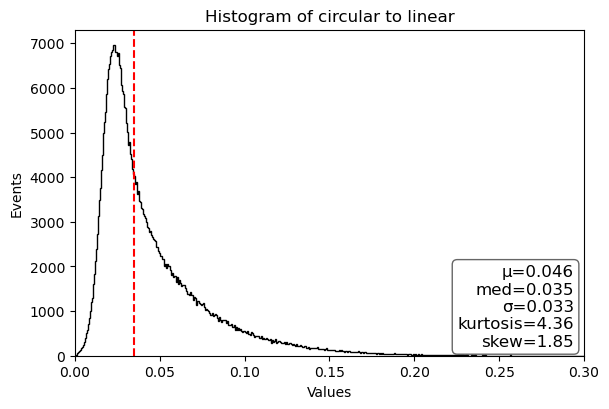

In [76]:
num_bins = 500
bin_range = (0,0.3)

# Prepare data
tissue_values = circular_to_linear_15[tissue_mask]

# Set up figure and axis properly
fig, ax = plt.subplots(figsize=(6, 4))

# Plot histogram on that axis
counts, bin_edges, _ = ax.hist(
    tissue_values, bins=num_bins, range=bin_range,
    color='black', histtype='step'
)

# Compute stats (assuming you've done this already)
stats_text = (
    f"μ={avg_circular_to_linear_15:.3f}\n"
    f"med={med_circular_to_linear_15:.3f}\n"
    f"σ={std_circular_to_linear_15:.3f}\n"
    f"kurtosis={kurt_circular_to_linear_15:.2f}\n"
    f"skew={skew_circular_to_linear_15:.2f}"
)

# Find quadrant with least activity
half = len(counts) // 2
q1 = np.mean(counts[:half // 2])      # top-left
q2 = np.mean(counts[half // 2:half])  # top-right
q3 = np.mean(counts[half:half + half // 2])  # bottom-left
q4 = np.mean(counts[half + half // 2:])      # bottom-right

quadrant_scores = {
    'top-left': q1,
    'top-right': q2,
    'bottom-left': q3,
    'bottom-right': q4
}
best_quadrant = min(quadrant_scores, key=quadrant_scores.get)

# Map best quadrant to axes-relative position
positions = {
    'top-left': (0.02, 0.98, 'left', 'top'),
    'top-right': (0.98, 0.98, 'right', 'top'),
    'bottom-left': (0.02, 0.02, 'left', 'bottom'),
    'bottom-right': (0.98, 0.02, 'right', 'bottom'),
}
x, y, ha, va = positions[best_quadrant]

# Place text dynamically within the plot (axes-relative coords)
ax.text(
    x, y, stats_text,
    transform=ax.transAxes,
    fontsize=12, va=va, ha=ha,
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.6)
)

# Add vertical line at median
ax.axvline(med_circular_to_linear_15, color='red', linestyle='--')

# Title and limits
ax.set_title('Histogram of circular to linear')
ax.set_xlim(bin_range)

plt.tight_layout()
plt.xlabel('Values')
plt.ylabel('Events')
plt.show()

In [77]:
# Linear_polar #

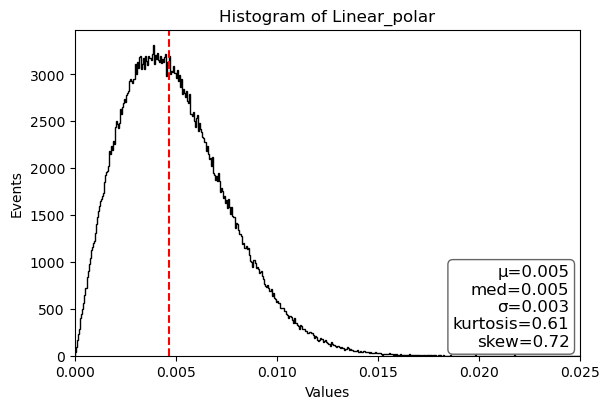

In [78]:
num_bins = 500
bin_range = (0,0.025)

# Prepare data
tissue_values = Linear_polar_15[tissue_mask]

# Set up figure and axis properly
fig, ax = plt.subplots(figsize=(6, 4))

# Plot histogram on that axis
counts, bin_edges, _ = ax.hist(
    tissue_values, bins=num_bins, range=bin_range,
    color='black', histtype='step'
)

# Compute stats (assuming you've done this already)
stats_text = (
    f"μ={avg_Linear_polar_15:.3f}\n"
    f"med={med_Linear_polar_15:.3f}\n"
    f"σ={std_Linear_polar_15:.3f}\n"
    f"kurtosis={kurt_Linear_polar_15:.2f}\n"
    f"skew={skew_Linear_polar_15:.2f}"
)

# Find quadrant with least activity
half = len(counts) // 2
q1 = np.mean(counts[:half // 2])      # top-left
q2 = np.mean(counts[half // 2:half])  # top-right
q3 = np.mean(counts[half:half + half // 2])  # bottom-left
q4 = np.mean(counts[half + half // 2:])      # bottom-right

quadrant_scores = {
    'top-left': q1,
    'top-right': q2,
    'bottom-left': q3,
    'bottom-right': q4
}
best_quadrant = min(quadrant_scores, key=quadrant_scores.get)

# Map best quadrant to axes-relative position
positions = {
    'top-left': (0.02, 0.98, 'left', 'top'),
    'top-right': (0.98, 0.98, 'right', 'top'),
    'bottom-left': (0.02, 0.02, 'left', 'bottom'),
    'bottom-right': (0.98, 0.02, 'right', 'bottom'),
}
x, y, ha, va = positions[best_quadrant]

# Place text dynamically within the plot (axes-relative coords)
ax.text(
    x, y, stats_text,
    transform=ax.transAxes,
    fontsize=12, va=va, ha=ha,
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.6)
)

# Add vertical line at median
ax.axvline(med_Linear_polar_15, color='red', linestyle='--')

# Title and limits
ax.set_title('Histogram of Linear_polar')
ax.set_xlim(bin_range)

plt.tight_layout()
plt.xlabel('Values')
plt.ylabel('Events')
plt.show()

In [79]:
# Linear_diat #

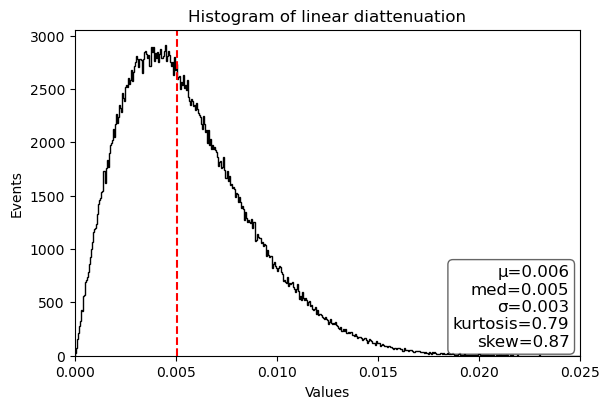

In [80]:
num_bins = 500
bin_range = (0,0.025)

# Prepare data
tissue_values = Linear_diat_15[tissue_mask]

# Set up figure and axis properly
fig, ax = plt.subplots(figsize=(6, 4))

# Plot histogram on that axis
counts, bin_edges, _ = ax.hist(
    tissue_values, bins=num_bins, range=bin_range,
    color='black', histtype='step'
)

# Compute stats (assuming you've done this already)
stats_text = (
    f"μ={avg_Linear_diat_15:.3f}\n"
    f"med={med_Linear_diat_15:.3f}\n"
    f"σ={std_Linear_diat_15:.3f}\n"
    f"kurtosis={kurt_Linear_diat_15:.2f}\n"
    f"skew={skew_Linear_diat_15:.2f}"
)

# Find quadrant with least activity
half = len(counts) // 2
q1 = np.mean(counts[:half // 2])      # top-left
q2 = np.mean(counts[half // 2:half])  # top-right
q3 = np.mean(counts[half:half + half // 2])  # bottom-left
q4 = np.mean(counts[half + half // 2:])      # bottom-right

quadrant_scores = {
    'top-left': q1,
    'top-right': q2,
    'bottom-left': q3,
    'bottom-right': q4
}
best_quadrant = min(quadrant_scores, key=quadrant_scores.get)

# Map best quadrant to axes-relative position
positions = {
    'top-left': (0.02, 0.98, 'left', 'top'),
    'top-right': (0.98, 0.98, 'right', 'top'),
    'bottom-left': (0.02, 0.02, 'left', 'bottom'),
    'bottom-right': (0.98, 0.02, 'right', 'bottom'),
}
x, y, ha, va = positions[best_quadrant]

# Place text dynamically within the plot (axes-relative coords)
ax.text(
    x, y, stats_text,
    transform=ax.transAxes,
    fontsize=12, va=va, ha=ha,
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.6)
)

# Add vertical line at median
ax.axvline(med_Linear_diat_15, color='red', linestyle='--')

# Title and limits
ax.set_title('Histogram of linear diattenuation')
ax.set_xlim(bin_range)

plt.tight_layout()
plt.xlabel('Values')
plt.ylabel('Events')
plt.show()

In [81]:
# beta #

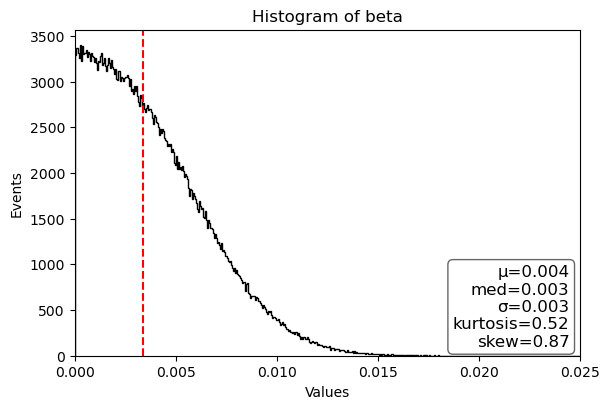

In [82]:
num_bins = 500
bin_range = (0,0.025)

# Prepare data
tissue_values = beta_15[tissue_mask]

# Set up figure and axis properly
fig, ax = plt.subplots(figsize=(6, 4))

# Plot histogram on that axis
counts, bin_edges, _ = ax.hist(
    tissue_values, bins=num_bins, range=bin_range,
    color='black', histtype='step'
)

# Compute stats (assuming you've done this already)
stats_text = (
    f"μ={avg_beta_15:.3f}\n"
    f"med={med_beta_15:.3f}\n"
    f"σ={std_beta_15:.3f}\n"
    f"kurtosis={kurt_beta_15:.2f}\n"
    f"skew={skew_beta_15:.2f}"
)

# Find quadrant with least activity
half = len(counts) // 2
q1 = np.mean(counts[:half // 2])      # top-left
q2 = np.mean(counts[half // 2:half])  # top-right
q3 = np.mean(counts[half:half + half // 2])  # bottom-left
q4 = np.mean(counts[half + half // 2:])      # bottom-right

quadrant_scores = {
    'top-left': q1,
    'top-right': q2,
    'bottom-left': q3,
    'bottom-right': q4
}
best_quadrant = min(quadrant_scores, key=quadrant_scores.get)

# Map best quadrant to axes-relative position
positions = {
    'top-left': (0.02, 0.98, 'left', 'top'),
    'top-right': (0.98, 0.98, 'right', 'top'),
    'bottom-left': (0.02, 0.02, 'left', 'bottom'),
    'bottom-right': (0.98, 0.02, 'right', 'bottom'),
}
x, y, ha, va = positions[best_quadrant]

# Place text dynamically within the plot (axes-relative coords)
ax.text(
    x, y, stats_text,
    transform=ax.transAxes,
    fontsize=12, va=va, ha=ha,
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.6)
)

# Add vertical line at median
ax.axvline(med_beta_15, color='red', linestyle='--')

# Title and limits
ax.set_title('Histogram of beta')
ax.set_xlim(bin_range)

plt.tight_layout()
plt.xlabel('Values')
plt.ylabel('Events')
plt.show()

In [83]:
# opt_rot #

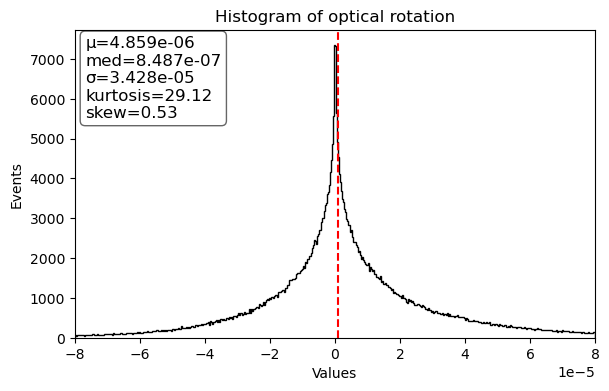

In [84]:
num_bins = 500
bin_range = (-8E-05,8E-05)

# Prepare data
tissue_values = opt_rot_15[tissue_mask]

# Set up figure and axis properly
fig, ax = plt.subplots(figsize=(6, 4))

# Plot histogram on that axis
counts, bin_edges, _ = ax.hist(
    tissue_values, bins=num_bins, range=bin_range,
    color='black', histtype='step'
)

# Compute stats (assuming you've done this already)
stats_text = (
    f"μ={np.format_float_scientific(avg_opt_rot_15, precision=3)}\n"
    f"med={np.format_float_scientific(med_opt_rot_15, precision=3)}\n"
    f"σ={np.format_float_scientific(std_opt_rot_15, precision=3)}\n"
    f"kurtosis={kurt_opt_rot_15:.2f}\n"
    f"skew={skew_opt_rot_15:.2f}"
)

# Find quadrant with least activity
half = len(counts) // 2
q1 = np.mean(counts[:half // 2])      # top-left
q2 = np.mean(counts[half // 2:half])  # top-right
q3 = np.mean(counts[half:half + half // 2])  # bottom-left
q4 = np.mean(counts[half + half // 2:])      # bottom-right

quadrant_scores = {
    'top-left': q1,
    'top-right': q2,
    'bottom-left': q3,
    'bottom-right': q4
}
best_quadrant = min(quadrant_scores, key=quadrant_scores.get)

# Map best quadrant to axes-relative position
positions = {
    'top-left': (0.02, 0.98, 'left', 'top'),
    'top-right': (0.98, 0.98, 'right', 'top'),
    'bottom-left': (0.02, 0.02, 'left', 'bottom'),
    'bottom-right': (0.98, 0.02, 'right', 'bottom'),
}
x, y, ha, va = positions[best_quadrant]

# Place text dynamically within the plot (axes-relative coords)
ax.text(
    x, y, stats_text,
    transform=ax.transAxes,
    fontsize=12, va=va, ha=ha,
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.6)
)

# Add vertical line at median
ax.axvline(med_opt_rot_15, color='red', linestyle='--')

# Title and limits
ax.set_title('Histogram of optical rotation')
ax.set_xlim(bin_range)

plt.tight_layout()
plt.xlabel('Values')
plt.ylabel('Events')
plt.show()